In [21]:
# ======================================
# Required Libraries
# ======================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interact
import re
from datetime import datetime

# ======================================
# Step 1: Define Helper Functions
# ======================================

def safe_divide(row):
    """
    Safely divide 'Asking Price' by 'MyHome_Floor_Area_Value'.
    Returns None if either value is NaN or if division by zero occurs.
    
    Args:
        row (pd.Series): A row from the DataFrame.
    
    Returns:
        float or None: The price per square meter or None.
    """
    if pd.isna(row['Asking Price']) or pd.isna(row['MyHome_Floor_Area_Value']) or row['MyHome_Floor_Area_Value'] == 0:
        return None
    else:
        return row['Asking Price'] / row['MyHome_Floor_Area_Value']

def get_price_details(price_changes: str):
    """
    Extracts the asking price at sale, sold price, sold date, and first list date from the Price Changes column.

    Args:
        price_changes (str): The value from the Price Changes column.

    Returns:
        tuple: A tuple containing:
            - Asking Price at Sale (float or None)
            - Sold Price (float or None)
            - Sold Date (str or None)
            - First List Date (str or None)
    """
    if not isinstance(price_changes, str):
        return (None, None, None, None)
    
    # Initialize variables
    sold_price = None
    sold_date = None
    asking_price_at_sale = None
    all_dates = []
    
    # Split the price changes by ';' to process each event separately
    entries = price_changes.split(';')
    
    for i, entry in enumerate(entries):
        entry = entry.strip()
        
        # Extract the date from the entry
        date_match = re.search(r"([A-Za-z]{3}\s+[A-Za-z]{3}\s+\d{1,2}\s+\d{4})", entry)
        if date_match:
            date_str = date_match.group(1)
            try:
                date_obj = datetime.strptime(date_str, "%a %b %d %Y")
                all_dates.append(date_obj)
            except ValueError:
                # Handle unexpected date formats
                pass
        
        # Match the 'Sold' event
        sold_match = re.match(
            r"Sold,\s*€([\d,]+),\s*([A-Za-z]{3}\s+[A-Za-z]{3}\s+\d{1,2}\s+\d{4})",
            entry,
            re.IGNORECASE
        )
        if sold_match:
            sold_price = float(sold_match.group(1).replace(',', ''))
            sold_date = sold_match.group(2)
            
            # Look for the next relevant event to find the asking price at sale
            for next_entry in entries[i+1:]:
                next_entry = next_entry.strip()
                asking_match = re.match(
                    r"(Sale Agreed|Price Drop|Created),\s*€([\d,]+),\s*[A-Za-z]{3}\s+[A-Za-z]{3}\s+\d{1,2}\s+\d{4}",
                    next_entry,
                    re.IGNORECASE
                )
                if asking_match:
                    asking_price_at_sale = float(asking_match.group(2).replace(',', ''))
                    break
            # Assuming only one 'Sold' event exists
            break
    
    # Determine the first list date (earliest date)
    if all_dates:
        first_list_date_obj = min(all_dates)
        first_list_date = first_list_date_obj.strftime("%a %b %d %Y")
    else:
        first_list_date = None
    
    return (asking_price_at_sale, sold_price, sold_date, first_list_date)

# ======================================
# Step 2: Load the Data
# ======================================

# Define the file path
file_path = '/Users/johnmcenroe/Documents/programming_misc/real_estate/data/processed/scraped_dublin/added_metadata/scraped_property_results_Dublin_final_with_metadata_deduped.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(file_path)

# ======================================
# Step 3: Data Cleaning and Preprocessing
# ======================================

# 3.1 Clean the 'Asking Price' Column
# -----------------------------------
# Remove any non-numeric characters (e.g., currency symbols, commas)
df['Asking Price'] = df['Asking Price'].replace({'[^0-9.]': ''}, regex=True)

# 3.2 Convert Columns to Numeric Types
# ------------------------------------
# Convert 'Asking Price' to numeric, coercing errors to NaN
df['Asking Price'] = pd.to_numeric(df['Asking Price'], errors='coerce')

# Convert 'MyHome_Floor_Area_Value' to numeric, coercing errors to NaN
df['MyHome_Floor_Area_Value'] = pd.to_numeric(df['MyHome_Floor_Area_Value'], errors='coerce')

# 3.3 Calculate Price per Square Meter
# ------------------------------------
# Apply the safe_divide function to create 'price_per_square_meter'
df['price_per_square_meter'] = df.apply(safe_divide, axis=1)

# 3.4 Extract Numeric Values from 'Beds' and 'Baths'
# ---------------------------------------------------
# Convert 'Beds' to string, extract numeric part, and convert to float
df['Beds'] = df['Beds'].astype(str).str.extract('(\d+)').astype(float)

# Convert 'Baths' to string, extract numeric part, and convert to float
df['Baths'] = df['Baths'].astype(str).str.extract('(\d+)').astype(float)

# ======================================
# Step 4: Add Boolean Columns
# ======================================

# 4.1 Define a list of property types considered as houses
house_types = [
    'End of Terrace', 'Terrace', 'Semi-D', 'Detached',
    'Duplex', 'Bungalow', 'Townhouse', 'Houses'
]

# 4.2 Add 'is_house' column indicating if the property is a house type
df['is_house'] = df['Property Type'].isin(house_types)

# ======================================
# Step 5: Extract Sold Price Details
# ======================================

# Apply the get_price_details function to extract details from 'Price Changes' column
df[['Sold Asking Price', 'Sold Price', 'Sold Date', 'First List Date']] = df['Price Changes'].apply(get_price_details).apply(pd.Series)

# 5.1 Convert 'Sold Asking Price' and 'Sold Price' to numeric types
df['Sold Asking Price'] = pd.to_numeric(df['Sold Asking Price'], errors='coerce')
df['Sold Price'] = pd.to_numeric(df['Sold Price'], errors='coerce')

# 5.2 Convert 'First List Date' to datetime format for better handling
df['First List Date'] = pd.to_datetime(df['First List Date'], format="%a %b %d %Y", errors='coerce')

# ======================================
# Step 6: Add 'my_home_listing' Boolean Column
# ======================================

# 6.1 Add 'my_home_listing' column indicating if 'price_per_square_meter' is greater than 0
df['my_home_listing'] = df['price_per_square_meter'] > 0

# ======================================
# Step 7: Final DataFrame Preview
# ======================================

# Display the first five rows of the updated DataFrame
print("Final DataFrame Preview:")
df.head(5)

# ======================================
# Step 8: (Optional) Save the Processed Data
# ======================================

# If you wish to save the processed DataFrame to a new CSV file
# df.to_csv('/path/to/save/processed_data.csv', index=False)


Final DataFrame Preview:


,Address,Asking Price,Beds,Baths,Property Type,Energy Rating,Eircode,Local Property Tax,Agency Name,Agency Contact,Price Changes,URL,MyHome_Address,MyHome_Asking_Price,MyHome_Beds,MyHome_Baths,MyHome_Floor_Area_Value,MyHome_BER_Rating,MyHome_Latitude,MyHome_Longitude,MyHome_Link,price_per_square_meter,is_house,Sold Asking Price,Sold Price,Sold Date,First List Date,my_home_listing
0,"Taramar, Middle Third, Dublin 5, D05X8N9",750000,4.0,1.0,End of Terrace,E2,D05 X8N9,€765,Hamill Estate Agents & Valuers,Hamill Estate Agents & Valuers,"Sold, €950,000, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/126051/Dublin/tarama...,"Taramar, Middle Third, Killester, Dublin 5",Sold,4 beds,NaN,142.0,NaN,53.373857,-6.203371,https://www.myhome.ie/residential/brochure/tar...,5281.690141,True,750000.0,950000.0,Fri Sep 13 2024,2024-09-13,True
1,"87 Haddington Road, Dublin 4, D04WP23",990000,5.0,3.0,Terrace,SI_666,D04 WP23,"€1,035",Turley Property Advisors,Susan Turley,"Sold, €1,010,000, Fri Sep 13 2024; Sale Agreed...",NaN,"87 Haddington Road, Ballsbridge, Dublin 4",Sold,5 beds,3 baths,175.0,NaN,53.335385,-6.239842,https://www.myhome.ie/residential/brochure/87-...,5657.142857,True,990000.0,1010000.0,Fri Sep 13 2024,2024-09-13,True
2,"Apartment 79, The Northumberlands, Love Lane E...",410000,2.0,1.0,Apartment,C1,D02 X068,€405,Owen Reilly,Owen Reilly Sales,"Sold, €480,000, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/134218/Dublin/apartm...,"79 The Northumberlands, Love Lane East, Mount ...",Sold,2 beds,NaN,64.0,NaN,53.349805,-6.260310,https://www.myhome.ie/residential/brochure/79-...,6406.250000,False,410000.0,480000.0,Fri Sep 13 2024,2024-09-13,True
3,"7 Parkside Heath, Clongriffin, Dublin 13, Dubl...",535000,3.0,3.0,Terrace,A3,D13 WN3C,€585,Sherry FitzGerald Sutton,Madeleine O'Connor,"Sold, €569,000, Fri Sep 13 2024; Unlisted, €53...",https://mynest.ie/listing/128619/Dublin/7-park...,"7 Parkside Heath, Balgriffin, Dublin 13",Sold,3 beds,3 baths,113.0,NaN,53.407653,-6.163418,https://www.myhome.ie/residential/brochure/7-p...,4734.513274,True,535000.0,569000.0,Fri Sep 13 2024,2024-09-13,True
4,"5 Herbert Road, Blanchardstown, Blanchardstown...",400000,2.0,1.0,Bungalow,D2,D15 A3TN,€405,Lloyd Daly & Associates Ltd.,Lloyd Daly & Associates - Sales,"Sold, €432,200, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/117502/Dublin/5-herb...,"5 Herbert Road, Blanchardstown, Dublin 15",Sold,2 beds,NaN,116.0,NaN,53.387605,-6.374562,https://www.myhome.ie/residential/brochure/5-h...,3448.275862,True,400000.0,432200.0,Fri Sep 13 2024,2024-09-13,True


In [22]:
df.head(10)

,Address,Asking Price,Beds,Baths,Property Type,Energy Rating,Eircode,Local Property Tax,Agency Name,Agency Contact,Price Changes,URL,MyHome_Address,MyHome_Asking_Price,MyHome_Beds,MyHome_Baths,MyHome_Floor_Area_Value,MyHome_BER_Rating,MyHome_Latitude,MyHome_Longitude,MyHome_Link,price_per_square_meter,is_house,Sold Asking Price,Sold Price,Sold Date,First List Date,my_home_listing
0,"Taramar, Middle Third, Dublin 5, D05X8N9",750000,4.0,1.0,End of Terrace,E2,D05 X8N9,€765,Hamill Estate Agents & Valuers,Hamill Estate Agents & Valuers,"Sold, €950,000, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/126051/Dublin/tarama...,"Taramar, Middle Third, Killester, Dublin 5",Sold,4 beds,NaN,142.0,NaN,53.373857,-6.203371,https://www.myhome.ie/residential/brochure/tar...,5281.690141,True,750000.0,950000.0,Fri Sep 13 2024,2024-09-13,True
1,"87 Haddington Road, Dublin 4, D04WP23",990000,5.0,3.0,Terrace,SI_666,D04 WP23,"€1,035",Turley Property Advisors,Susan Turley,"Sold, €1,010,000, Fri Sep 13 2024; Sale Agreed...",NaN,"87 Haddington Road, Ballsbridge, Dublin 4",Sold,5 beds,3 baths,175.0,NaN,53.335385,-6.239842,https://www.myhome.ie/residential/brochure/87-...,5657.142857,True,990000.0,1010000.0,Fri Sep 13 2024,2024-09-13,True
2,"Apartment 79, The Northumberlands, Love Lane E...",410000,2.0,1.0,Apartment,C1,D02 X068,€405,Owen Reilly,Owen Reilly Sales,"Sold, €480,000, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/134218/Dublin/apartm...,"79 The Northumberlands, Love Lane East, Mount ...",Sold,2 beds,NaN,64.0,NaN,53.349805,-6.260310,https://www.myhome.ie/residential/brochure/79-...,6406.250000,False,410000.0,480000.0,Fri Sep 13 2024,2024-09-13,True
3,"7 Parkside Heath, Clongriffin, Dublin 13, Dubl...",535000,3.0,3.0,Terrace,A3,D13 WN3C,€585,Sherry FitzGerald Sutton,Madeleine O'Connor,"Sold, €569,000, Fri Sep 13 2024; Unlisted, €53...",https://mynest.ie/listing/128619/Dublin/7-park...,"7 Parkside Heath, Balgriffin, Dublin 13",Sold,3 beds,3 baths,113.0,NaN,53.407653,-6.163418,https://www.myhome.ie/residential/brochure/7-p...,4734.513274,True,535000.0,569000.0,Fri Sep 13 2024,2024-09-13,True
4,"5 Herbert Road, Blanchardstown, Blanchardstown...",400000,2.0,1.0,Bungalow,D2,D15 A3TN,€405,Lloyd Daly & Associates Ltd.,Lloyd Daly & Associates - Sales,"Sold, €432,200, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/117502/Dublin/5-herb...,"5 Herbert Road, Blanchardstown, Dublin 15",Sold,2 beds,NaN,116.0,NaN,53.387605,-6.374562,https://www.myhome.ie/residential/brochure/5-h...,3448.275862,True,400000.0,432200.0,Fri Sep 13 2024,2024-09-13,True
5,"Apartment 40, The Swift, Tassagard Greens, Sag...",290000,2.0,2.0,Apartment,B3,D24 KF58,€315,Smith & Butler Estates,Danny Butler,"Sold, €340,000, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/106324/Dublin/apartm...,NaN,NaN,NaN,NaN,NaN,NaN,53.281393,-6.440669,https://www.myhome.ie/priceregister/40-the-swi...,NaN,False,290000.0,340000.0,Fri Sep 13 2024,2024-09-13,False
6,"31 Tibradden Grove, Dublin 12, D12P2X4",355000,3.0,1.0,Terrace,D1,D12 P2X4,€405,Byrne and Moore Property Consultants Limited,Bryne & Moore Property,"Sold, €390,000, Fri Sep 13 2024; Sale Agreed, ...",NaN,"14, Tibradden Grove, Greenpark, Walkinstown, D...",Sold,3 beds,NaN,106.0,NaN,53.308228,-6.341920,https://www.myhome.ie/residential/brochure/14-...,3349.056604,True,355000.0,390000.0,Fri Sep 13 2024,2024-09-13,True
7,"Apartment 207, The Edges 1, Beacon South Quart...",375000,2.0,2.0,Apartment,B3,D18 KX68,€405,Herbert & Lansdowne Estate Agents,Sales Department,"Sold, €387,000, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/109892/Dublin/apartm...,"207 The Edges 1, Beacon South Quarter, Sandyfo...",Sold,2 beds,2 baths,64.0,NaN,53.277970,-6.216868,https://www.myhome.ie/residential/brochure/207...,5859.375000,False,375000.0,387000.0,Fri Sep 13 2024,2024-09-13,True
8,"80 Moatfield Road, Coolock, Coolock, Dublin 5,...",395000,3.0,1.0,Terrace,E1,D05 X9C0,€405,Hamill Estate Agents & Valu

In [23]:
row_count = pd.read_csv(file_path).shape[0]
print(f"Number of rows: {row_count}")


Number of rows: 1821


In [24]:
df[df['price_per_square_meter'].isna()].head(5)

,Address,Asking Price,Beds,Baths,Property Type,Energy Rating,Eircode,Local Property Tax,Agency Name,Agency Contact,Price Changes,URL,MyHome_Address,MyHome_Asking_Price,MyHome_Beds,MyHome_Baths,MyHome_Floor_Area_Value,MyHome_BER_Rating,MyHome_Latitude,MyHome_Longitude,MyHome_Link,price_per_square_meter,is_house,Sold Asking Price,Sold Price,Sold Date,First List Date,my_home_listing
5,"Apartment 40, The Swift, Tassagard Greens, Sag...",290000,2.0,2.0,Apartment,B3,D24 KF58,€315,Smith & Butler Estates,Danny Butler,"Sold, €340,000, Fri Sep 13 2024; Sale Agreed, ...",https://mynest.ie/listing/106324/Dublin/apartm...,NaN,NaN,NaN,NaN,NaN,NaN,53.281393,-6.440669,https://www.myhome.ie/priceregister/40-the-swi...,NaN,False,290000.0,340000.0,Fri Sep 13 2024,2024-09-13,False
18,"43 Hayestown, Rush, Co. Dublin",319950,2.0,1.0,Bungalow,D1,K56 Y206,€315,Leonard Wilson Keenan Estates & Letting Agents,Multi Award Winning Team Richard Todd,"Sold, €453,000, Thu Sep 12 2024; Unlisted, €31...",https://mynest.ie/listing/66930/Dublin/43-haye...,"43 Hayestown, Rush, Dublin",Sale Agreed,2 beds,NaN,NaN,NaN,53.524124,-6.113056,https://www.myhome.ie/residential/brochure/43-...,NaN,True,319950.0,453000.0,Thu Sep 12 2024,2024-09-12,False
19,"43 Hayestown, Rush, Co. Dublin, K56Y206",365000,2.0,1.0,Bungalow,D1,K56 Y206,€405,Leonard Wilson Keenan Estates & Letting Agents,Richard Todd,"Sold, €453,000, Thu Sep 12 2024; Unlisted, €36...",https://mynest.ie/listing/116836/Dublin/43-hay...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,365000.0,453000.0,Thu Sep 12 2024,2024-09-12,False
25,"183 Charlemont, Griffith Avenue, Drumcondra, D...",525000,3.0,1.0,Terrace,C3,D09 E5W4,€495,KELLY BRADSHAW DALTON,Sharon Beckett,"Sold, €530,000, Thu Sep 12 2024; Sale Agreed, ...",https://mynest.ie/listing/131480/Dublin/183-ch...,"147 Charlemont, Griffith Avenue, Drumcondra, D...",Sale Agreed,4 beds,3 baths,NaN,NaN,53.376708,-6.233381,https://www.myhome.ie/residential/brochure/147...,NaN,True,525000.0,530000.0,Thu Sep 12 2024,2024-09-12,False
31,"Apartment 6, 45 Saint Anthony's Road, Rialto, ...",350000,2.0,2.0,Apartment,SI_666,D08 XD73,€315,Keller Williams Ireland,Team Castles,"Sold, €390,000, Wed Sep 11 2024; Sale Agreed, ...",https://mynest.ie/listing/122564/Dublin/apartm...,"Apartment 6, 45 St Anthonys Road, Rialto, Dubl...",Sold,2 beds,2 baths,NaN,NaN,53.337832,-6.293655,https://www.myhome.ie/residential/brochure/apa...,NaN,False,350000.0,390000.0,Wed Sep 11 2024,2024-09-11,False


In [25]:
# Get the statistical summary of the dataset
df_description = df.describe()

# Display the description
df_description

,Asking Price,Beds,Baths,MyHome_Floor_Area_Value,MyHome_BER_Rating,MyHome_Latitude,MyHome_Longitude,price_per_square_meter,Sold Asking Price,Sold Price,First List Date
count,1.821000e+03,1814.000000,1797.000000,1080.000000,0.0,1783.000000,1783.000000,1080.000000,1.819000e+03,1.821000e+03,1821
mean,5.800460e+05,2.880375,1.965498,105.739648,NaN,53.306174,-6.172207,5354.982428,5.788349e+05,6.223314e+05,2024-08-11 22:39:20.461285120
min,1.500000e+05,1.000000,1.000000,24.000000,NaN,-20.706854,-6.482501,994.318182,1.500000e+05,8.000000e+04,2024-03-28 00:00:00
25%,3.499500e+05,2.000000,1.000000,71.000000,NaN,53.290903,-6.304371,4159.702692,3.490000e+05,3.800000e+05,2024-07-30 00:00:00
50%,4.490000e+05,3.000000,2.000000,93.325000,NaN,53.338714,-6.247742,5111.455108,4.490000e+05,4.850000e+05,2024-08-14 00:00:00
75%,6.750000e+05,3.000000,3.000000,125.000000,NaN,53.384024,-6.193442,6294.117647,6.750000e+05,7.250000e+05,2024-08-28 00:00:00
max,6.750000e+06,9.000000,7.000000,498.000000,NaN,53.617567,140.505325,22551.546392,6.750000e+06,7.255000e+06,2024-09-13 00:00:00
std,4.346970e+05,1.070345,0.956708,53.140745,NaN,1.755186,3.476683,1714.005612,4.339369e+05,4.501594e+05,NaN


In [26]:
# Display column names as a list
def get_column_info(df):
    return pd.DataFrame({'Column Name': df.columns, 'Data Type': df.dtypes})

print(get_column_info(df))


                                     Column Name       Data Type
Address                                  Address          object
Asking Price                        Asking Price           int64
Beds                                        Beds         float64
Baths                                      Baths         float64
Property Type                      Property Type          object
Energy Rating                      Energy Rating          object
Eircode                                  Eircode          object
Local Property Tax            Local Property Tax          object
Agency Name                          Agency Name          object
Agency Contact                    Agency Contact          object
Price Changes                      Price Changes          object
URL                                          URL          object
MyHome_Address                    MyHome_Address          object
MyHome_Asking_Price          MyHome_Asking_Price          object
MyHome_Beds              

In [27]:
print(df['Energy Rating'].unique())

['E2' 'SI_666' 'C1' 'A3' 'D2' 'B3' 'D1' 'E1' 'C2' 'C3' 'B2' 'G' 'F' 'A2'
 '--' 'B1' 'A1']


In [28]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
from math import radians, sin, cos, sqrt, atan2

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth.
    """
    # Earth radius in kilometers
    R = 6371.0

    # Convert coordinates to radians
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)

    # Differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def ber_to_numeric(ber):
    """
    Convert BER rating to a numeric value.
    A1 is the best (highest value), G is the worst (lowest value).
    """
    ber_order = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F', 'G']
    if pd.isna(ber) or ber == '--' or ber not in ber_order:
        return np.nan
    return float(len(ber_order) - ber_order.index(ber))

def preprocess_dataframe(df):
    """
    Preprocess the dataframe by converting columns to appropriate data types and handling missing values.
    """
    try:
        # Define required columns with their expected data types
        required_columns = {
            'Sold Date': 'datetime',
            'Price Changes': 'numeric',
            'Local Property Tax': 'numeric',
            'MyHome_Asking_Price': 'numeric',
            'MyHome_Beds': 'numeric',
            'MyHome_Baths': 'numeric',
            'First List Date': 'datetime',
            'Energy Rating': 'string',  # Changed to string
            'MyHome_Latitude': 'numeric',
            'MyHome_Longitude': 'numeric'
        }

        # Ensure column names are stripped of leading/trailing spaces
        df.columns = df.columns.str.strip()

        # Remove 'MyHome_BER_Rating' if it exists
        if 'MyHome_BER_Rating' in df.columns:
            df.drop(columns=['MyHome_BER_Rating'], inplace=True)
            logging.info("Removed 'MyHome_BER_Rating' column as it's no longer needed.")

        # Convert and handle each required column
        for col, dtype in required_columns.items():
            if col in df.columns:
                if dtype == 'datetime':
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                elif dtype == 'numeric':
                    # Remove non-numeric characters before conversion
                    df[col] = pd.to_numeric(
                        df[col].astype(str).str.replace('[^\d.]', '', regex=True), errors='coerce'
                    )
                elif dtype == 'string':
                    df[col] = df[col].astype(str)
            else:
                logging.warning(f"'{col}' column is missing. Filling with NaN or default values.")
                if dtype == 'datetime':
                    df[col] = pd.NaT
                elif dtype == 'numeric':
                    df[col] = np.nan
                elif dtype == 'string':
                    df[col] = ''

        # Handle 'First List Date' missing values
        if 'First List Date' in df.columns:
            missing_first_list_date = df['First List Date'].isna().sum()
            if missing_first_list_date > 0:
                if 'Sold Date' in df.columns:
                    df['First List Date'] = df['First List Date'].fillna(df['Sold Date'] - timedelta(days=30))
                    logging.info("Filled missing 'First List Date' with 'Sold Date' minus 30 days.")
                else:
                    df['First List Date'] = df['First List Date'].fillna(datetime.now() - timedelta(days=30))
                    logging.info("Filled missing 'First List Date' with current date minus 30 days.")

        # Handle other numeric columns
        numeric_columns = [
            'Asking Price', 'Beds', 'Baths', 'MyHome_Asking_Price',
            'MyHome_Beds', 'MyHome_Baths', 'MyHome_Floor_Area_Value',
            'Local Property Tax', 'Sold Asking Price',
            'Sold Price', 'price_per_square_meter'
        ]

        # Clean and convert numeric columns
        for col in numeric_columns:
            if col in df.columns:
                # Remove non-numeric characters except decimal points
                df[col] = pd.to_numeric(
                    df[col].astype(str).str.replace('[^\d.]', '', regex=True), errors='coerce'
                )
                # Fill missing values with median or a default value if median is NaN
                median_value = df[col].median()
                if pd.isna(median_value):
                    median_value = 0  # Default value if median is NaN
                df[col] = df[col].fillna(median_value)
                logging.info(f"Filled missing values in '{col}' with median: {median_value}")
            else:
                df[col] = np.nan
                logging.warning(f"'{col}' column is missing. Filling with NaN.")

        # Convert BER ratings to numeric values
        if 'Energy Rating' in df.columns:
            df['Energy Rating'] = df['Energy Rating'].apply(ber_to_numeric)
            logging.info("Converted BER ratings to numeric values.")

        # Ensure 'Geo Distance (km)' is removed as it will be calculated per row
        if 'Geo Distance (km)' in df.columns:
            df.drop(columns=['Geo Distance (km)'], inplace=True)
            logging.info("Removed precomputed 'Geo Distance (km)' to calculate it per row.")

        # Initialize 'Dynamic Geo Distance (km)' as 0.0 (placeholder)
        df['Dynamic Geo Distance (km)'] = 0.0

        # Handle 'Property Type' consistency
        if 'Property Type' in df.columns:
            df['Property Type'] = df['Property Type'].astype(str).str.title().str.strip()
        else:
            df['Property Type'] = 'Unknown'
            logging.warning("'Property Type' column is missing. Filled with 'Unknown'.")

        return df

    except Exception as e:
        logging.error(f"Error in preprocessing dataframe: {e}")
        raise

def calculate_metrics_for_row(df, row):
    """
    Calculate all metrics for a single row and return a dictionary of new columns.
    """
    new_columns = {}

    # Extract the current property's latitude and longitude
    current_lat = row.get('MyHome_Latitude', np.nan)
    current_lon = row.get('MyHome_Longitude', np.nan)

    if pd.isna(current_lat) or pd.isna(current_lon):
        logging.warning(f"Missing latitude or longitude for row index {row.name}. Skipping metrics calculation.")
        return new_columns  # Return empty metrics if location data is missing

    # Calculate distances from the current property to all other properties
    df = df.copy()  # To avoid SettingWithCopyWarning
    df['Dynamic Geo Distance (km)'] = df.apply(
        lambda r: haversine_distance(current_lat, current_lon, r['MyHome_Latitude'], r['MyHome_Longitude'])
        if pd.notna(r['MyHome_Latitude']) and pd.notna(r['MyHome_Longitude']) else np.nan,
        axis=1
    )

    # Define metric categories with distances and time frames
    transaction_volume_categories = {
        '3km_90days': {'distance': 3, 'days': 90},
        '5km_180days': {'distance': 5, 'days': 180}
    }

    transaction_value_categories = {
        '3km_90days': {'distance': 3, 'days': 90},
        '5km_180days': {'distance': 5, 'days': 180}
    }

    price_dynamics_categories = {
        '3km_90days': {'distance': 3, 'days': 90},
        '5km_180days': {'distance': 5, 'days': 180}
    }

    time_based_categories = {
        '3km': {'distance': 3},
        '5km': {'distance': 5}
    }

    property_condition_categories = {
        '3km': {'distance': 3},
        '5km': {'distance': 5}
    }

    house_size_benchmark_categories = {
        '3km_90days': {'distance': 3, 'days': 90},
        '5km_180days': {'distance': 5, 'days': 180}
    }

    property_type_distribution_categories = {
        '3km': {'distance': 3},
        '5km': {'distance': 5}
    }

    listing_activity_categories = {
        '3km': {'distance': 3},
        '5km': {'distance': 5}
    }

    sales_velocity_categories = {
        '3km': {'distance': 3, 'months': 6},
        '5km': {'distance': 5, 'months': 6}
    }

    pricing_consistency_categories = {
        '3km': {'distance': 3},
        '5km': {'distance': 5, 'days': 180}
    }

    # Transaction Volume Metrics
    for key, params in transaction_volume_categories.items():
        distance = params['distance']
        days = params['days']
        mask = (df['Dynamic Geo Distance (km)'] <= distance) & (df['Sold Date'] >= (row['Sold Date'] - timedelta(days=days)))
        filtered = df[mask]
        num_sold = filtered.shape[0]
        new_columns[f'transaction_volume_num_sold_within_{distance}km_{days}days'] = num_sold

        if days >= 30:
            months = days / 30
            avg_monthly = num_sold / months if months > 0 else np.nan
            new_columns[f'transaction_volume_avg_monthly_transactions_within_{distance}km'] = avg_monthly
        else:
            new_columns[f'transaction_volume_avg_monthly_transactions_within_{distance}km'] = np.nan

        if key == '3km_90days':
            total_listings = df[
                (df['Dynamic Geo Distance (km)'] <= distance) &
                (df['First List Date'] >= (row['Sold Date'] - timedelta(days=days)))
            ].shape[0]
            new_columns[f'transaction_volume_total_listings_last_{days}days_within_{distance}km'] = total_listings

    # Transaction Value Metrics
    for key, params in transaction_value_categories.items():
        distance = params['distance']
        days = params['days']
        mask = (df['Dynamic Geo Distance (km)'] <= distance) & (df['Sold Date'] >= (row['Sold Date'] - timedelta(days=days)))
        filtered = df[mask]

        if 'Sold Price' in df.columns and not filtered.empty:
            median_sold_price = filtered['Sold Price'].median()
            new_columns[f'transaction_value_median_sold_price_within_{distance}km_{days}days'] = median_sold_price

            percentile_75_sold_price = filtered['Sold Price'].quantile(0.75)
            new_columns[f'transaction_value_p75_sold_price_within_{distance}km_{days}days'] = percentile_75_sold_price
        else:
            new_columns[f'transaction_value_median_sold_price_within_{distance}km_{days}days'] = np.nan
            new_columns[f'transaction_value_p75_sold_price_within_{distance}km_{days}days'] = np.nan

        if 'price_per_square_meter' in df.columns and not filtered.empty:
            avg_price_sqm = filtered['price_per_square_meter'].mean()
            new_columns[f'transaction_value_avg_price_per_sqm_within_{distance}km'] = avg_price_sqm
        else:
            new_columns[f'transaction_value_avg_price_per_sqm_within_{distance}km'] = np.nan

        if key == '5km_180days' and 'Sold Price' in df.columns and not filtered.empty:
            avg_sold_price = filtered['Sold Price'].mean()
            new_columns[f'transaction_value_avg_sold_price_within_{distance}km_{days}days'] = avg_sold_price

        if key == '3km_90days' and 'Asking Price' in df.columns and not filtered.empty:
            median_asking_price = filtered['Asking Price'].median()
            new_columns[f'transaction_value_median_asking_price_within_{distance}km_{days}days'] = median_asking_price

    # Price Dynamics Metrics
    for key, params in price_dynamics_categories.items():
        distance = params['distance']
        days = params['days']
        mask = (df['Dynamic Geo Distance (km)'] <= distance) & (df['Sold Date'] >= (row['Sold Date'] - timedelta(days=days)))
        filtered = df[mask].copy()

        if 'Sold Price' in filtered.columns and 'Asking Price' in filtered.columns and not filtered.empty:
            filtered['Price_Difference'] = filtered['Sold Price'] - filtered['Asking Price']
            avg_price_diff = filtered['Price_Difference'].mean()
            new_columns[f'price_dynamics_avg_price_diff_within_{distance}km_{days}days'] = avg_price_diff

            filtered_non_zero = filtered[filtered['Asking Price'] != 0]
            if not filtered_non_zero.empty:
                filtered_non_zero['Price_Change_Pct'] = (filtered_non_zero['Price_Difference'] / filtered_non_zero['Asking Price']) * 100
                median_price_change_pct = filtered_non_zero['Price_Change_Pct'].median()
                new_columns[f'price_dynamics_median_price_change_pct_within_{distance}km_{days}days'] = median_price_change_pct

                percent_above = (filtered_non_zero['Sold Price'] > filtered_non_zero['Asking Price']).mean() * 100
                new_columns[f'price_dynamics_percent_sold_above_asking_within_{distance}km_{days}days'] = percent_above
            else:
                new_columns[f'price_dynamics_median_price_change_pct_within_{distance}km_{days}days'] = np.nan
                new_columns[f'price_dynamics_percent_sold_above_asking_within_{distance}km_{days}days'] = np.nan
        else:
            new_columns[f'price_dynamics_avg_price_diff_within_{distance}km_{days}days'] = np.nan
            new_columns[f'price_dynamics_median_price_change_pct_within_{distance}km_{days}days'] = np.nan
            new_columns[f'price_dynamics_percent_sold_above_asking_within_{distance}km_{days}days'] = np.nan

    # Time-Based Metrics
    for key, params in time_based_categories.items():
        distance = params['distance']
        mask = (df['Dynamic Geo Distance (km)'] <= distance)
        filtered = df[mask].copy()

        if 'Sold Date' in filtered.columns and 'First List Date' in filtered.columns:
            # Calculate Days_on_Market safely
            filtered['Days_on_Market'] = (filtered['Sold Date'] - filtered['First List Date']).dt.days
            avg_days = filtered['Days_on_Market'].mean() if not filtered['Days_on_Market'].empty else np.nan
            median_days = filtered['Days_on_Market'].median() if not filtered['Days_on_Market'].empty else np.nan
            new_columns[f'time_based_avg_days_on_market_within_{distance}km'] = avg_days
            new_columns[f'time_based_median_days_on_market_within_{distance}km'] = median_days
        else:
            new_columns[f'time_based_avg_days_on_market_within_{distance}km'] = np.nan
            new_columns[f'time_based_median_days_on_market_within_{distance}km'] = np.nan

        if key == '5km':
            if 'Days_on_Market' in filtered.columns and not filtered['Days_on_Market'].empty:
                avg_time_to_sell = filtered['Days_on_Market'].mean()
                new_columns['time_based_avg_time_to_sell_within_5km'] = avg_time_to_sell

                mask_days = (df['Sold Date'] >= (row['Sold Date'] - timedelta(days=180)))
                filtered_days = df[mask & mask_days]
                if 'Days_on_Market' in filtered_days.columns and not filtered_days['Days_on_Market'].empty:
                    median_time_on_market = filtered_days['Days_on_Market'].median()
                    new_columns['time_based_median_time_on_market_last_180days_within_5km'] = median_time_on_market
                else:
                    new_columns['time_based_median_time_on_market_last_180days_within_5km'] = np.nan
            else:
                new_columns['time_based_avg_time_to_sell_within_5km'] = np.nan
                new_columns['time_based_median_time_on_market_last_180days_within_5km'] = np.nan

        if key == '3km':
            mask_listings = (df['Dynamic Geo Distance (km)'] <= distance) & \
                            (df['First List Date'] >= (row['Sold Date'] - timedelta(days=90)))
            total_listings = df[mask_listings].shape[0]
            new_columns['time_based_total_listings_last_90days_within_3km'] = total_listings

    # Property Condition Metrics
    # Using 'Energy Rating' instead of 'MyHome_BER_Rating'
    # Energy Rating Distribution within 3 km
    distance = 3
    if 'Dynamic Geo Distance (km)' in df.columns and 'Energy Rating' in df.columns:
        mask = (df['Dynamic Geo Distance (km)'] <= distance)
        filtered = df[mask]
        if not filtered.empty:
            ber_distribution = filtered['Energy Rating'].value_counts(normalize=True).sort_index() * 100
            for ber, percent in ber_distribution.items():
                if pd.notna(ber) and ber != '--':
                    new_columns[f'property_condition_ber_dist_{ber}_within_{distance}km'] = percent
        else:
            logging.warning("No data available for BER distribution within 3 km.")
    else:
        logging.warning("Required columns for BER distribution are missing.")

    # Percentage of BER Rating A within 5 km
    distance = 5
    if 'Dynamic Geo Distance (km)' in df.columns and 'Energy Rating' in df.columns:
        mask = (df['Dynamic Geo Distance (km)'] <= distance)
        filtered = df[mask]
        if not filtered.empty:
            # Assuming BER Rating A corresponds to the highest rating, e.g., 15 (from ber_to_numeric)
            ber_a_value = df['Energy Rating'].max()  # Adjust based on 'ber_to_numeric' mapping
            ber_a_percent = (filtered['Energy Rating'] == ber_a_value).mean() * 100
            new_columns[f'property_condition_percent_ber_A_within_{distance}km'] = ber_a_percent
        else:
            new_columns[f'property_condition_percent_ber_A_within_{distance}km'] = np.nan
    else:
        logging.warning("Required columns for BER rating percentage are missing.")

    # Average BER Rating within 3 km
    distance = 3
    if 'Dynamic Geo Distance (km)' in df.columns and 'Energy Rating' in df.columns:
        mask = (df['Dynamic Geo Distance (km)'] <= distance)
        filtered = df[mask]
        if not filtered.empty:
            avg_ber = filtered['Energy Rating'].mean()
            new_columns[f'property_condition_avg_ber_within_{distance}km'] = avg_ber
        else:
            new_columns[f'property_condition_avg_ber_within_{distance}km'] = np.nan
    else:
        logging.warning("Required columns for average BER rating are missing.")

    # Percentage of Energy Efficient Homes within 3 km (BER Rating >=5 assuming 5-7 are efficient)
    distance = 3
    if 'Dynamic Geo Distance (km)' in df.columns and 'Energy Rating' in df.columns:
        mask = (df['Dynamic Geo Distance (km)'] <= distance)
        filtered = df[mask]
        if not filtered.empty:
            energy_efficient_percent = ((filtered['Energy Rating'] >= 5) & (filtered['Energy Rating'] <= 7)).mean() * 100
            new_columns[f'property_condition_percent_energy_efficient_within_{distance}km'] = energy_efficient_percent
        else:
            new_columns[f'property_condition_percent_energy_efficient_within_{distance}km'] = np.nan
    else:
        logging.warning("Required columns for energy efficiency percentage are missing.")

    # Median BER Rating within 5 km in Last 180 Days
    distance = 5
    days = 180
    if 'Dynamic Geo Distance (km)' in df.columns and 'Sold Date' in df.columns and 'Energy Rating' in df.columns:
        mask = (df['Dynamic Geo Distance (km)'] <= distance) & \
               (df['Sold Date'] >= (row['Sold Date'] - timedelta(days=days)))
        filtered = df[mask]
        if not filtered.empty:
            median_ber = filtered['Energy Rating'].median()
            new_columns[f'property_condition_median_ber_within_{distance}km_{days}days'] = median_ber
        else:
            new_columns[f'property_condition_median_ber_within_{distance}km_{days}days'] = np.nan
    else:
        logging.warning("Required columns for median BER rating are missing.")

    # House Size Benchmark Metrics
    for key, params in house_size_benchmark_categories.items():
        distance = params['distance']
        days = params['days']
        mask = (df['Dynamic Geo Distance (km)'] <= distance) & (df['Sold Date'] >= (row['Sold Date'] - timedelta(days=days)))
        filtered = df[mask]

        if 'MyHome_Floor_Area_Value' in filtered.columns and not filtered['MyHome_Floor_Area_Value'].empty:
            avg_floor_area = filtered['MyHome_Floor_Area_Value'].mean()
            new_columns[f'house_size_benchmark_avg_floor_area_within_{distance}km_{days}days'] = avg_floor_area
        else:
            avg_floor_area = np.nan
            new_columns[f'house_size_benchmark_avg_floor_area_within_{distance}km_{days}days'] = np.nan

        if 'MyHome_Beds' in filtered.columns and not filtered['MyHome_Beds'].empty:
            median_beds = filtered['MyHome_Beds'].median()
            new_columns[f'house_size_benchmark_median_beds_within_{distance}km_{days}days'] = median_beds
        else:
            median_beds = np.nan
            new_columns[f'house_size_benchmark_median_beds_within_{distance}km_{days}days'] = np.nan

        if 'MyHome_Baths' in filtered.columns and not filtered['MyHome_Baths'].empty:
            median_baths = filtered['MyHome_Baths'].median()
            new_columns[f'house_size_benchmark_median_baths_within_{distance}km_{days}days'] = median_baths
        else:
            median_baths = np.nan
            new_columns[f'house_size_benchmark_median_baths_within_{distance}km_{days}days'] = np.nan

        if 'MyHome_Floor_Area_Value' in filtered.columns and not filtered['MyHome_Floor_Area_Value'].empty:
            std_floor_area = filtered['MyHome_Floor_Area_Value'].std()
            new_columns[f'house_size_benchmark_std_floor_area_within_{distance}km'] = std_floor_area
        else:
            new_columns[f'house_size_benchmark_std_floor_area_within_{distance}km'] = np.nan

        if 'MyHome_Floor_Area_Value' in df.columns and not pd.isna(avg_floor_area):
            percent_larger = (df['MyHome_Floor_Area_Value'] > avg_floor_area).mean() * 100
            new_columns[f'house_size_benchmark_percent_larger_than_avg_within_{distance}km_{days}days'] = percent_larger
        else:
            new_columns[f'house_size_benchmark_percent_larger_than_avg_within_{distance}km_{days}days'] = np.nan

        # Comparison Indicators
        if 'MyHome_Floor_Area_Value' in df.columns and not pd.isna(avg_floor_area):
            new_columns[f'house_size_comparison_larger_than_avg_within_{distance}km_{days}days'] = (df['MyHome_Floor_Area_Value'] > avg_floor_area).astype(float)
        else:
            new_columns[f'house_size_comparison_larger_than_avg_within_{distance}km_{days}days'] = np.nan

        if 'MyHome_Beds' in df.columns and not pd.isna(median_beds):
            new_columns[f'house_size_comparison_beds_above_median_within_{distance}km_{days}days'] = (df['MyHome_Beds'] > median_beds).astype(float)
        else:
            new_columns[f'house_size_comparison_beds_above_median_within_{distance}km_{days}days'] = np.nan

        if 'MyHome_Baths' in df.columns and not pd.isna(median_baths):
            new_columns[f'house_size_comparison_baths_above_median_within_{distance}km_{days}days'] = (df['MyHome_Baths'] > median_baths).astype(float)
        else:
            new_columns[f'house_size_comparison_baths_above_median_within_{distance}km_{days}days'] = np.nan

    # Property Type Distribution Metrics
    for key, params in property_type_distribution_categories.items():
        distance = params['distance']
        mask = (df['Dynamic Geo Distance (km)'] <= distance)
        filtered = df[mask]

        if 'Property Type' in filtered.columns and not filtered['Property Type'].empty:
            # Distribution of Property Types
            property_counts = filtered['Property Type'].value_counts(normalize=True) * 100
            for prop_type, percent in property_counts.items():
                new_columns[f'property_type_dist_{prop_type}_percent_within_{distance}km'] = percent

            # Percentage of Each Property Type
            for prop_type in df['Property Type'].unique():
                percent = (filtered['Property Type'] == prop_type).mean() * 100 if not filtered.empty else np.nan
                new_columns[f'property_type_percent_{prop_type}_within_{distance}km'] = percent

            # Median Property Type Count within 3 km in Last 90 Days
            if key == '3km' and 'First List Date' in df.columns:
                days = 90
                mask_days = (df['First List Date'] >= (row['Sold Date'] - timedelta(days=days)))
                filtered_days = df[mask & mask_days]
                if 'Property Type' in filtered_days.columns and not filtered_days['Property Type'].empty:
                    median_prop_count = filtered_days['Property Type'].value_counts().median()
                    new_columns[f'property_type_median_count_within_{distance}km_{days}days'] = median_prop_count
                else:
                    new_columns[f'property_type_median_count_within_{distance}km_{days}days'] = np.nan

            # Diversity Index of Property Types within 5 km
            if key == '5km':
                diversity = filtered['Property Type'].nunique()
                new_columns[f'property_type_diversity_within_{distance}km'] = diversity

            # Number of Unique Property Types within 3 km
            if key == '3km':
                unique_prop_types = filtered['Property Type'].nunique()
                new_columns[f'property_type_unique_count_within_{distance}km'] = unique_prop_types
        else:
            logging.warning("Required columns for property type distribution are missing or empty.")

    # Listing Activity Metrics
    for key, params in listing_activity_categories.items():
        distance = params['distance']

        if key == '3km':
            # Active Listings: Listings without a Sold Date
            mask_active = (df['Dynamic Geo Distance (km)'] <= distance) & (df['Sold Date'].isna())
            num_active = df[mask_active].shape[0]
            new_columns[f'listing_activity_num_active_within_{distance}km'] = num_active

            # Median Asking Price of Active Listings within 3 km
            if 'Asking Price' in df.columns and not df.loc[mask_active, 'Asking Price'].empty:
                median_asking = df.loc[mask_active, 'Asking Price'].median()
                new_columns[f'listing_activity_median_asking_price_active_within_{distance}km'] = median_asking
            else:
                new_columns[f'listing_activity_median_asking_price_active_within_{distance}km'] = np.nan

            # Average Number of Price Changes within 3 km
            if 'Price Changes' in df.columns and not df.loc[mask_active, 'Price Changes'].empty:
                avg_price_changes = df.loc[mask_active, 'Price Changes'].fillna(0).mean()
                new_columns[f'listing_activity_avg_price_changes_within_{distance}km'] = avg_price_changes
            else:
                new_columns[f'listing_activity_avg_price_changes_within_{distance}km'] = np.nan

        if key == '5km':
            # Active Listings: Listings without a Sold Date
            mask_active = (df['Dynamic Geo Distance (km)'] <= distance) & (df['Sold Date'].isna())
            active_listings = df[mask_active].copy()
            if 'First List Date' in active_listings.columns and not active_listings['First List Date'].isna().all():
                active_listings['Days_on_Market'] = (row['Sold Date'] - active_listings['First List Date']).dt.days
                avg_time_on_market = active_listings['Days_on_Market'].mean() if not active_listings['Days_on_Market'].empty else np.nan
                new_columns[f'listing_activity_avg_days_on_market_active_within_{distance}km'] = avg_time_on_market
            else:
                new_columns[f'listing_activity_avg_days_on_market_active_within_{distance}km'] = np.nan

            # Percentage of Listings with Price Changes within 5 km
            if 'Price Changes' in df.columns and not df[df['Dynamic Geo Distance (km)'] <= distance]['Price Changes'].empty:
                percent_price_changes = ((df['Dynamic Geo Distance (km)'] <= distance) & df['Price Changes'].notna()).mean() * 100
                new_columns[f'listing_activity_percent_price_changes_within_{distance}km'] = percent_price_changes
            else:
                new_columns[f'listing_activity_percent_price_changes_within_{distance}km'] = np.nan

    # Sales Velocity Metrics
    for key, params in sales_velocity_categories.items():
        distance = params['distance']
        months = params['months']
        start_date = row['Sold Date'] - pd.DateOffset(months=months)

        mask = (df['Dynamic Geo Distance (km)'] <= distance) & (df['Sold Date'] >= start_date)
        filtered = df[mask]

        # Average Sales Velocity (Properties Sold per Month)
        sales_velocity_avg = filtered.shape[0] / months if months > 0 else np.nan
        new_columns[f'sales_velocity_avg_properties_sold_per_month_within_{distance}km'] = sales_velocity_avg

        # Median Sales Velocity
        if not filtered.empty:
            monthly_sales = filtered.groupby(filtered['Sold Date'].dt.to_period('M')).size()
            sales_velocity_median = monthly_sales.median() if not monthly_sales.empty else np.nan
            new_columns[f'sales_velocity_median_properties_sold_per_month_within_{distance}km'] = sales_velocity_median
        else:
            new_columns[f'sales_velocity_median_properties_sold_per_month_within_{distance}km'] = np.nan

        # Sales Velocity Trend over Last 6 Months within 3 km
        if key == '3km' and not filtered.empty:
            monthly_sales = filtered.groupby(filtered['Sold Date'].dt.to_period('M')).size()
            for period, count in monthly_sales.items():
                new_columns[f'sales_velocity_count_{period}_within_{distance}km'] = count

        # Seasonal Sales Velocity Patterns within 5 km
        if key == '5km' and not filtered.empty:
            # Ensure that 'Month' is correctly set using .loc to avoid SettingWithCopyWarning
            filtered = filtered.copy()
            filtered['Month'] = filtered['Sold Date'].dt.month
            seasonal_sales = filtered.groupby('Month').size()
            for month, count in seasonal_sales.items():
                new_columns[f'sales_velocity_seasonal_month_{month}_within_{distance}km'] = count

        # Comparative Sales Velocity between 3 km and 5 km Radii
        if key == '5km':
            # Calculate sales velocity for 3 km if not already present
            mask_3km = (df['Dynamic Geo Distance (km)'] <= 3) & (df['Sold Date'] >= (row['Sold Date'] - pd.DateOffset(months=6)))
            filtered_3km = df[mask_3km]
            sales_velocity_avg_3km = filtered_3km.shape[0] / 6 if 6 > 0 else np.nan
            new_columns['sales_velocity_comparative_3km_vs_5km'] = sales_velocity_avg - sales_velocity_avg_3km

    # Pricing Consistency Metrics
    for key, params in pricing_consistency_categories.items():
        distance = params['distance']
        days = params.get('days', None)

        mask = (df['Dynamic Geo Distance (km)'] <= distance)
        filtered = df[mask].copy()

        # Average Asking Price vs. Sold Price Ratio within distance
        if 'Sold Price' in filtered.columns and 'Asking Price' in filtered.columns and not filtered.empty:
            filtered_non_zero = filtered[filtered['Asking Price'] != 0]
            if not filtered_non_zero.empty:
                asking_sold_ratio = filtered_non_zero['Sold Price'] / filtered_non_zero['Asking Price']
                avg_ratio = asking_sold_ratio.mean()
                new_columns[f'pricing_consistency_avg_asking_sold_ratio_within_{distance}km'] = avg_ratio
            else:
                new_columns[f'pricing_consistency_avg_asking_sold_ratio_within_{distance}km'] = np.nan
        else:
            new_columns[f'pricing_consistency_avg_asking_sold_ratio_within_{distance}km'] = np.nan

        # Median Price Adjustment Ratio within 5 km in Last 180 Days
        if key == '5km' and days:
            mask_days = (df['Sold Date'] >= (row['Sold Date'] - timedelta(days=days)))
            filtered_days = df[mask & mask_days]
            if 'Sold Price' in filtered_days.columns and 'Asking Price' in filtered_days.columns and not filtered_days.empty:
                filtered_days_non_zero = filtered_days[filtered_days['Asking Price'] != 0]
                if not filtered_days_non_zero.empty:
                    median_ratio = (filtered_days_non_zero['Sold Price'] / filtered_days_non_zero['Asking Price']).median()
                    new_columns[f'pricing_consistency_median_asking_sold_ratio_within_{distance}km_{days}days'] = median_ratio
                else:
                    new_columns[f'pricing_consistency_median_asking_sold_ratio_within_{distance}km_{days}days'] = np.nan
            else:
                new_columns[f'pricing_consistency_median_asking_sold_ratio_within_{distance}km_{days}days'] = np.nan

        # Percentage of Listings with Consistent Pricing (Minimal Changes) within 3 km
        if key == '3km':
            consistent_threshold = 5  # Define what constitutes minimal change, e.g., <=5%
            if 'Price Changes' in filtered.columns and 'Asking Price' in filtered.columns and not filtered.empty:
                filtered_non_zero = filtered[filtered['Asking Price'] != 0].copy()
                if not filtered_non_zero.empty:
                    filtered_non_zero['Price_Change_Pct'] = (filtered_non_zero['Price Changes'] / filtered_non_zero['Asking Price']) * 100
                    percent_consistent = (filtered_non_zero['Price_Change_Pct'].abs() <= consistent_threshold).mean() * 100
                    new_columns[f'pricing_consistency_percent_minimal_changes_within_{distance}km'] = percent_consistent
                else:
                    new_columns[f'pricing_consistency_percent_minimal_changes_within_{distance}km'] = np.nan
            else:
                new_columns[f'pricing_consistency_percent_minimal_changes_within_{distance}km'] = np.nan

        # Average Time Between Price Changes within 5 km
        if key == '5km':
            if 'Price Changes' in filtered.columns and not filtered['Price Changes'].empty:
                avg_time_between_changes = filtered['Price Changes'].fillna(0).mean()
                new_columns[f'pricing_consistency_avg_time_between_changes_within_{distance}km'] = avg_time_between_changes
            else:
                new_columns[f'pricing_consistency_avg_time_between_changes_within_{distance}km'] = np.nan

        # Price Change Frequency within 3 km
        if key == '3km':
            if 'Price Changes' in filtered.columns and not filtered['Price Changes'].empty:
                price_change_freq = (filtered['Price Changes'].fillna(0) > 0).mean() * 100
                new_columns[f'pricing_consistency_price_change_freq_within_{distance}km'] = price_change_freq
            else:
                new_columns[f'pricing_consistency_price_change_freq_within_{distance}km'] = np.nan

    return new_columns

def add_all_metrics(df):
    """
    Add all calculated metrics to the dataframe.
    """
    try:
        # Preprocess the dataframe
        df = preprocess_dataframe(df)

        # Initialize a list to store metrics dictionaries
        metrics_list = []

        # Iterate over each row to calculate metrics
        for idx, row in df.iterrows():
            logging.info(f"Calculating metrics for row {idx + 1}/{len(df)}")
            metrics = calculate_metrics_for_row(df, row)
            metrics_list.append(metrics)

        # Create a DataFrame from the list of metrics
        metrics_df = pd.DataFrame(metrics_list)

        # Concatenate metrics to the original DataFrame
        df = pd.concat([df.reset_index(drop=True), metrics_df.reset_index(drop=True)], axis=1)

        # Drop the 'Dynamic Geo Distance (km)' column as it's no longer needed
        if 'Dynamic Geo Distance (km)' in df.columns:
            df.drop(columns=['Dynamic Geo Distance (km)'], inplace=True)

        logging.info("All metrics have been successfully added to the dataframe.")
        return df

    except Exception as e:
        logging.error(f"Error in adding all metrics: {e}")
        raise

# Example usage:
if __name__ == "__main__":
    df_sample = df  # Ensure 'df' is defined with your data

    # Add all metrics
    df_with_metrics = add_all_metrics(df_sample)

    # Display the dataframe with new metrics
    pd.set_option('display.max_columns', None)  # Show all columns for clarity
    print(df_with_metrics.head())


INFO: Removed 'MyHome_BER_Rating' column as it's no longer needed.
INFO: Filled missing values in 'Asking Price' with median: 449000.0
INFO: Filled missing values in 'Beds' with median: 3.0
INFO: Filled missing values in 'Baths' with median: 2.0
INFO: Filled missing values in 'MyHome_Asking_Price' with median: 367500.0
INFO: Filled missing values in 'MyHome_Beds' with median: 3.0
INFO: Filled missing values in 'MyHome_Baths' with median: 2.0
INFO: Filled missing values in 'MyHome_Floor_Area_Value' with median: 93.325
INFO: Filled missing values in 'Local Property Tax' with median: 495.0
INFO: Filled missing values in 'Sold Asking Price' with median: 449000.0
INFO: Filled missing values in 'Sold Price' with median: 485000.0
INFO: Filled missing values in 'price_per_square_meter' with median: 5111.455108359133
INFO: Converted BER ratings to numeric values.
INFO: Calculating metrics for row 1/1821
INFO: Calculating metrics for row 2/1821
INFO: Calculating metrics for row 3/1821
INFO: Calc

                                             Address  Asking Price  Beds  \
0           Taramar, Middle Third, Dublin 5, D05X8N9        750000   4.0   
1              87 Haddington Road, Dublin 4, D04WP23        990000   5.0   
2  Apartment 79, The Northumberlands, Love Lane E...        410000   2.0   
3  7 Parkside Heath, Clongriffin, Dublin 13, Dubl...        535000   3.0   
4  5 Herbert Road, Blanchardstown, Blanchardstown...        400000   2.0   

   Baths   Property Type  Energy Rating   Eircode  Local Property Tax  \
0    1.0  End Of Terrace            3.0  D05 X8N9                 765   
1    3.0         Terrace            NaN  D04 WP23                1035   
2    1.0       Apartment            9.0  D02 X068                 405   
3    3.0         Terrace           13.0  D13 WN3C                 585   
4    1.0        Bungalow            5.0  D15 A3TN                 405   

                      Agency Name                   Agency Contact  \
0  Hamill Estate Agents & Valuers 

In [30]:
df_with_metrics.head(10)

,Address,Asking Price,Beds,Baths,Property Type,Energy Rating,Eircode,Local Property Tax,Agency Name,Agency Contact,Price Changes,URL,MyHome_Address,MyHome_Asking_Price,MyHome_Beds,MyHome_Baths,MyHome_Floor_Area_Value,MyHome_Latitude,MyHome_Longitude,MyHome_Link,price_per_square_meter,is_house,Sold Asking Price,Sold Price,Sold Date,First List Date,my_home_listing,transaction_volume_num_sold_within_3km_90days,transaction_volume_avg_monthly_transactions_within_3km,transaction_volume_total_listings_last_90days_within_3km,transaction_volume_num_sold_within_5km_180days,transaction_volume_avg_monthly_transactions_within_5km,transaction_value_median_sold_price_within_3km_90days,transaction_value_p75_sold_price_within_3km_90days,transaction_value_avg_price_per_sqm_within_3km,transaction_value_median_asking_price_within_3km_90days,transaction_value_median_sold_price_within_5km_180days,transaction_value_p75_sold_price_within_5km_180days,transaction_value_avg_price_per_sqm_within_5km,transaction_value_avg_sold_price_within_5km_180days,price_dynamics_avg_price_diff_within_3km_90days,price_dynamics_median_price_change_pct_within_3km_90days,price_dynamics_percent_sold_above_asking_within_3km_90days,price_dynamics_avg_price_diff_within_5km_180days,price_dynamics_median_price_change_pct_within_5km_180days,price_dynamics_percent_sold_above_asking_within_5km_180days,time_based_avg_days_on_market_within_3km,time_based_median_days_on_market_within_3km,time_based_total_listings_last_90days_within_3km,time_based_avg_days_on_market_within_5km,time_based_median_days_on_market_within_5km,time_based_avg_time_to_sell_within_5km,time_based_median_time_on_market_last_180days_within_5km,property_condition_ber_dist_1.0_within_3km,property_condition_ber_dist_2.0_within_3km,property_condition_ber_dist_3.0_within_3km,property_condition_ber_dist_4.0_within_3km,property_condition_ber_dist_5.0_within_3km,property_condition_ber_dist_6.0_within_3km,property_condition_ber_dist_7.0_within_3km,property_condition_ber_dist_8.0_within_3km,property_condition_ber_dist_9.0_within_3km,property_condition_ber_dist_10.0_within_3km,property_condition_ber_dist_11.0_within_3km,property_condition_ber_dist_13.0_within_3km,property_condition_ber_dist_14.0_within_3km,property_condition_percent_ber_A_within_5km,property_condition_avg_ber_within_3km,property_condition_percent_energy_efficient_within_3km,property_condition_median_ber_within_5km_180days,house_size_benchmark_avg_floor_area_within_3km_90days,house_size_benchmark_median_beds_within_3km_90days,house_size_benchmark_median_baths_within_3km_90days,house_size_benchmark_std_floor_area_within_3km,house_size_benchmark_percent_larger_than_avg_within_3km_90days,house_size_comparison_larger_than_avg_within_3km_90days,house_size_comparison_beds_above_median_within_3km_90days,house_size_comparison_baths_above_median_within_3km_90days,house_size_benchmark_avg_floor_area_within_5km_180days,house_size_benchmark_median_beds_within_5km_180days,house_size_benchmark_median_baths_within_5km_180days,house_size_benchmark_std_floor_area_within_5km,house_size_benchmark_percent_larger_than_avg_within_5km_180days,house_size_comparison_larger_than_avg_within_5km_180days,house_size_comparison_beds_above_median_within_5km_180days,house_size_comparison_baths_above_median_within_5km_180days,property_type_dist_Terrace_percent_within_3km,property_type_dist_Semi-D_percent_within_3km,property_type_dist_End Of Terrace_percent_within_3km,property_type_dist_Apartment_percent_within_3km,property_type_dist_Detached_percent_within_3km,property_type_percent_End Of Terrace_within_3km,property_type_percent_Terrace_within_3km,property_type_percent_Apartment_within_3km,property_type_percent_Bungalow_within_3km,property_type_percent_Semi-D_within_3km,property_type_percent_Detached_within_3km,property_type_percent_Duplex_within_3km,property_type_percent_Studio_within_3km,property_type_percent_Townhouse_within_3km,property_type_percent_Houses_within_3km,property_type_percent

In [31]:
# Filter the DataFrame to keep only rows where the specified column is not NaN
filtered_df = df_with_metrics[df_with_metrics['transaction_volume_num_sold_within_3km_90days'].notna()]

# Display the first 20 rows of the filtered DataFrame
filtered_df.head(10)


,Address,Asking Price,Beds,Baths,Property Type,Energy Rating,Eircode,Local Property Tax,Agency Name,Agency Contact,Price Changes,URL,MyHome_Address,MyHome_Asking_Price,MyHome_Beds,MyHome_Baths,MyHome_Floor_Area_Value,MyHome_Latitude,MyHome_Longitude,MyHome_Link,price_per_square_meter,is_house,Sold Asking Price,Sold Price,Sold Date,First List Date,my_home_listing,transaction_volume_num_sold_within_3km_90days,transaction_volume_avg_monthly_transactions_within_3km,transaction_volume_total_listings_last_90days_within_3km,transaction_volume_num_sold_within_5km_180days,transaction_volume_avg_monthly_transactions_within_5km,transaction_value_median_sold_price_within_3km_90days,transaction_value_p75_sold_price_within_3km_90days,transaction_value_avg_price_per_sqm_within_3km,transaction_value_median_asking_price_within_3km_90days,transaction_value_median_sold_price_within_5km_180days,transaction_value_p75_sold_price_within_5km_180days,transaction_value_avg_price_per_sqm_within_5km,transaction_value_avg_sold_price_within_5km_180days,price_dynamics_avg_price_diff_within_3km_90days,price_dynamics_median_price_change_pct_within_3km_90days,price_dynamics_percent_sold_above_asking_within_3km_90days,price_dynamics_avg_price_diff_within_5km_180days,price_dynamics_median_price_change_pct_within_5km_180days,price_dynamics_percent_sold_above_asking_within_5km_180days,time_based_avg_days_on_market_within_3km,time_based_median_days_on_market_within_3km,time_based_total_listings_last_90days_within_3km,time_based_avg_days_on_market_within_5km,time_based_median_days_on_market_within_5km,time_based_avg_time_to_sell_within_5km,time_based_median_time_on_market_last_180days_within_5km,property_condition_ber_dist_1.0_within_3km,property_condition_ber_dist_2.0_within_3km,property_condition_ber_dist_3.0_within_3km,property_condition_ber_dist_4.0_within_3km,property_condition_ber_dist_5.0_within_3km,property_condition_ber_dist_6.0_within_3km,property_condition_ber_dist_7.0_within_3km,property_condition_ber_dist_8.0_within_3km,property_condition_ber_dist_9.0_within_3km,property_condition_ber_dist_10.0_within_3km,property_condition_ber_dist_11.0_within_3km,property_condition_ber_dist_13.0_within_3km,property_condition_ber_dist_14.0_within_3km,property_condition_percent_ber_A_within_5km,property_condition_avg_ber_within_3km,property_condition_percent_energy_efficient_within_3km,property_condition_median_ber_within_5km_180days,house_size_benchmark_avg_floor_area_within_3km_90days,house_size_benchmark_median_beds_within_3km_90days,house_size_benchmark_median_baths_within_3km_90days,house_size_benchmark_std_floor_area_within_3km,house_size_benchmark_percent_larger_than_avg_within_3km_90days,house_size_comparison_larger_than_avg_within_3km_90days,house_size_comparison_beds_above_median_within_3km_90days,house_size_comparison_baths_above_median_within_3km_90days,house_size_benchmark_avg_floor_area_within_5km_180days,house_size_benchmark_median_beds_within_5km_180days,house_size_benchmark_median_baths_within_5km_180days,house_size_benchmark_std_floor_area_within_5km,house_size_benchmark_percent_larger_than_avg_within_5km_180days,house_size_comparison_larger_than_avg_within_5km_180days,house_size_comparison_beds_above_median_within_5km_180days,house_size_comparison_baths_above_median_within_5km_180days,property_type_dist_Terrace_percent_within_3km,property_type_dist_Semi-D_percent_within_3km,property_type_dist_End Of Terrace_percent_within_3km,property_type_dist_Apartment_percent_within_3km,property_type_dist_Detached_percent_within_3km,property_type_percent_End Of Terrace_within_3km,property_type_percent_Terrace_within_3km,property_type_percent_Apartment_within_3km,property_type_percent_Bungalow_within_3km,property_type_percent_Semi-D_within_3km,property_type_percent_Detached_within_3km,property_type_percent_Duplex_within_3km,property_type_percent_Studio_within_3km,property_type_percent_Townhouse_within_3km,property_type_percent_Houses_within_3km,property_type_percent

In [32]:
def get_column_info(df):
    return list(df.columns)

print(get_column_info(df_with_metrics))


['Address', 'Asking Price', 'Beds', 'Baths', 'Property Type', 'Energy Rating', 'Eircode', 'Local Property Tax', 'Agency Name', 'Agency Contact', 'Price Changes', 'URL', 'MyHome_Address', 'MyHome_Asking_Price', 'MyHome_Beds', 'MyHome_Baths', 'MyHome_Floor_Area_Value', 'MyHome_Latitude', 'MyHome_Longitude', 'MyHome_Link', 'price_per_square_meter', 'is_house', 'Sold Asking Price', 'Sold Price', 'Sold Date', 'First List Date', 'my_home_listing', 'transaction_volume_num_sold_within_3km_90days', 'transaction_volume_avg_monthly_transactions_within_3km', 'transaction_volume_total_listings_last_90days_within_3km', 'transaction_volume_num_sold_within_5km_180days', 'transaction_volume_avg_monthly_transactions_within_5km', 'transaction_value_median_sold_price_within_3km_90days', 'transaction_value_p75_sold_price_within_3km_90days', 'transaction_value_avg_price_per_sqm_within_3km', 'transaction_value_median_asking_price_within_3km_90days', 'transaction_value_median_sold_price_within_5km_180days', '

In [33]:
import pandas as pd

# Function to return column statistics including mean, median, 75th percentile, and non-null counts
def get_column_info_with_stats(df):
    # Filter numeric columns
    numeric_columns = df_with_metrics.select_dtypes(include=['number']).columns
    
    # Create the base DataFrame with column names and data types
    stats = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes
    })
    
    # Calculate statistics only for numeric columns
    stats['Mean'] = df[numeric_columns].mean()
    stats['Median'] = df[numeric_columns].median()
    stats['75th Percentile'] = df[numeric_columns].quantile(0.75)
    
    # Calculate the count of non-null values for all columns
    stats['Non-null Count'] = df.notnull().sum()

    return stats

# Example usage with your dataframe
# Assuming `df_with_metrics` is your dataframe with metrics
df_stats = get_column_info_with_stats(df_with_metrics)

# Display the first 30 rows
df_stats.head(30)


,Column Name,Data Type,Mean,Median,75th Percentile,Non-null Count
Address,Address,object,NaN,NaN,NaN,1821
Asking Price,Asking Price,int64,5.800460e+05,4.490000e+05,6.750000e+05,1821
Beds,Beds,float64,2.880835e+00,3.000000e+00,3.000000e+00,1821
Baths,Baths,float64,1.965953e+00,2.000000e+00,3.000000e+00,1821
Property Type,Property Type,object,NaN,NaN,NaN,1821
Energy Rating,Energy Rating,float64,7.071676e+00,7.000000e+00,9.000000e+00,1730
Eircode,Eircode,object,NaN,NaN,NaN,1821
Local Property Tax,Local Property Tax,int64,6.275409e+02,4.950000e+02,6.750000e+02,1821
Agency Name,Agency Name,object,NaN,NaN,NaN,1812
Agency Contact,Agency Contact,object,NaN,NaN,NaN,1821


In [34]:
# COPY THIS
df = df_with_metrics

scikit-learn version: 1.5.2
Initial Data Shape: (1821, 163)

Data Types:
Address                                          object
Asking Price                                      int64
Beds                                            float64
Baths                                           float64
Property Type                                    object
                                                 ...   
property_type_dist_Site_percent_within_5km      float64
sales_velocity_seasonal_month_3_within_5km      float64
sales_velocity_count_2024-03_within_3km         float64
property_type_dist_Houses_percent_within_3km    float64
property_condition_ber_dist_15.0_within_3km     float64
Length: 163, dtype: object

Dropped 'price_per_square_meter' column.

Dropped columns: ['Address', 'URL', 'MyHome_Address', 'MyHome_Link', 'Agency Name', 'Agency Contact', 'Sold Asking Price', 'Sold Price', 'Sold Date', 'First List Date', 'Local Property Tax']

Features shape: (1821, 150)
Target shape: (1821,)

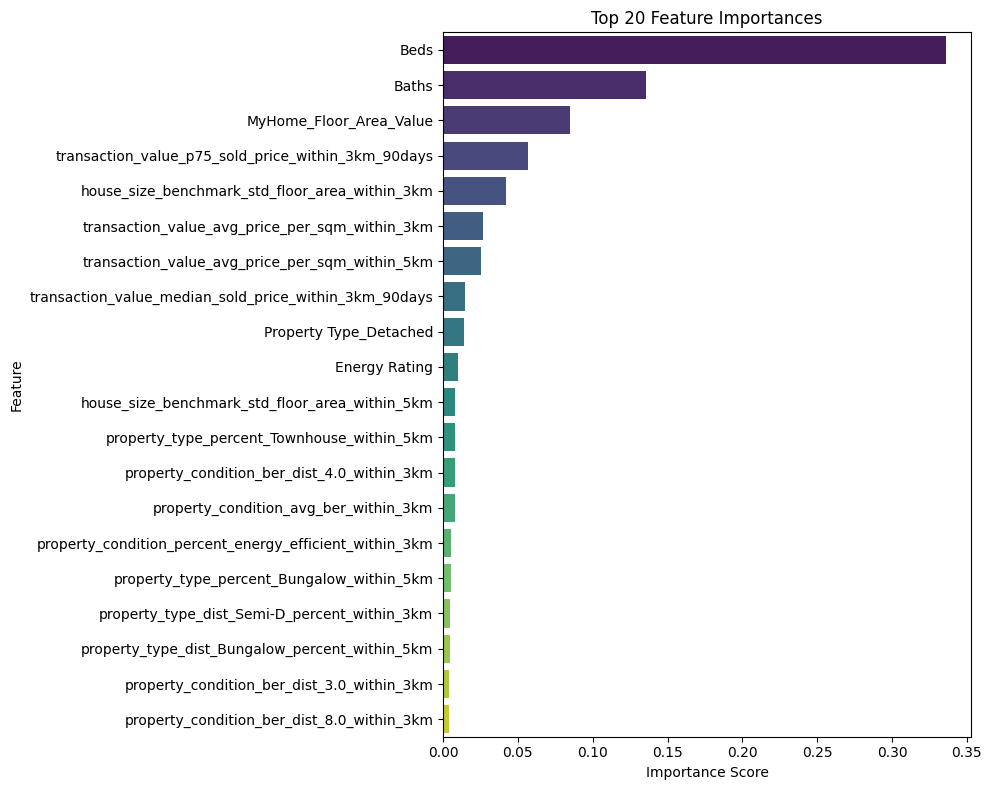

In [35]:
import pandas as pd
import numpy as np

# For preprocessing and model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# For handling missing values
from sklearn.impute import SimpleImputer

# For evaluation
from sklearn.metrics import mean_squared_error, r2_score

# For feature importance visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For version checking
import sklearn
from packaging import version

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Check scikit-learn version
sklearn_version = sklearn.__version__
print(f"scikit-learn version: {sklearn_version}")

# 1. Load the Data
# Replace 'house_data.csv' with your actual data file path
df = df_with_metrics

# 2. Initial Data Inspection
print("Initial Data Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

# 3. Drop the 'price_per_square_meter' Column if present
if 'price_per_square_meter' in df.columns:
    df = df.drop('price_per_square_meter', axis=1)
    print("\nDropped 'price_per_square_meter' column.")

# 4. Drop Irrelevant, Leakage Columns, and Ensure Local Property Tax is Removed
columns_to_drop = [
    'Address', 'URL', 'MyHome_Address', 'MyHome_Link',
    'Agency Name', 'Agency Contact', 'Sold Asking Price',
    'Sold Price', 'Sold Date', 'First List Date',
    'Local Property Tax'  # Corrected column name
]

# Drop columns if they exist in the dataframe
existing_drop_columns = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_drop_columns, axis=1)
print(f"\nDropped columns: {existing_drop_columns}")

# 5. Define the Target Variable
target = 'Asking Price'

if target not in df.columns:
    raise ValueError(f"Target variable '{target}' not found in the dataset.")

# 6. Separate Features and Target
X = df.drop(target, axis=1)
y = df[target]

print("\nFeatures shape:", X.shape)
print("Target shape:", y.shape)

# 7. Further Drop Columns that May Cause Leakage or Are Irrelevant
leakage_columns = [
    'transaction_volume_num_sold_within_3km_90days',
    'transaction_volume_avg_monthly_transactions_within_3km'
]

existing_leakage_columns = [col for col in leakage_columns if col in X.columns]
X = X.drop(columns=existing_leakage_columns, axis=1)
print(f"\nDropped leakage columns: {existing_leakage_columns}")

# 8. Identify Numerical and Categorical Columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# 9. Handle High Cardinality Columns (Optional)
if 'Eircode' in categorical_cols:
    X = X.drop('Eircode', axis=1)
    categorical_cols.remove('Eircode')
    print("\nDropped 'Eircode' due to high cardinality.")

# 10. Ensure Numerical Columns are Numeric
for col in numerical_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# 11. Ensure Categorical Columns are of type 'str'
for col in categorical_cols:
    X[col] = X[col].astype(str)

# 12. Check for Remaining Missing Values
print("\nMissing values per column:")
print(X.isnull().sum())

# 13. Drop Columns with Excessive Missing Values
threshold = 0.5  # Drop columns with more than 50% missing values
missing_fraction = X.isnull().mean()
columns_to_drop_missing = missing_fraction[missing_fraction > threshold].index.tolist()
if columns_to_drop_missing:
    X = X.drop(columns=columns_to_drop_missing, axis=1)
    numerical_cols = [col for col in numerical_cols if col not in columns_to_drop_missing]
    categorical_cols = [col for col in categorical_cols if col not in columns_to_drop_missing]
    print(f"\nDropped columns with >50% missing values: {columns_to_drop_missing}")

# 14. Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Adjust OneHotEncoder parameter based on scikit-learn version
if version.parse(sklearn_version) >= version.parse("1.2"):
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', onehot_encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 15. Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# 16. Create the Modeling Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    ))
])

# 17. Train the Model
try:
    model_pipeline.fit(X_train, y_train)
    print("\nModel training completed.")
except ValueError as e:
    print("\nError during model training:", e)
    raise

# 18. Make Predictions on the Test Set
y_pred = model_pipeline.predict(X_test)

# 19. Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest Regressor Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.2f}")

# 20. Feature Importance Analysis
def get_feature_names(preprocessor, numerical_cols, categorical_cols):
    output_features = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            output_features.extend(columns)
        elif name == 'cat':
            onehot = transformer.named_steps['onehot']
            if hasattr(onehot, 'get_feature_names_out'):
                cat_features = onehot.get_feature_names_out(columns)
            else:
                cat_features = onehot.get_feature_names(columns)
            output_features.extend(cat_features)
    return output_features

feature_names = get_feature_names(preprocessor, numerical_cols, categorical_cols)

if len(feature_names) != len(model_pipeline.named_steps['regressor'].feature_importances_):
    raise ValueError("Mismatch between number of feature names and feature importances.")

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_pipeline.named_steps['regressor'].feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

top_n = 20
top_features = feature_importances.head(top_n)

print(f"\nTop {top_n} Feature Importances:")
print(top_features)

# 21. Visualize Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


scikit-learn version: 1.5.2
Initial Data Shape: (1821, 152)

Data Types:
Address                                          object
Asking Price                                      int64
Beds                                            float64
Baths                                           float64
Property Type                                    object
                                                 ...   
property_type_dist_Houses_percent_within_5km    float64
property_type_dist_Site_percent_within_5km      float64
sales_velocity_seasonal_month_3_within_5km      float64
sales_velocity_count_2024-03_within_3km         float64
property_type_dist_Houses_percent_within_3km    float64
Length: 152, dtype: object

Preserved Columns:
                                             Address  Beds  Baths  Sold Price  \
0           Taramar, Middle Third, Dublin 5, D05X8N9   4.0    1.0    950000.0   
1              87 Haddington Road, Dublin 4, D04WP23   5.0    3.0   1010000.0   
2  Apartment 79, The 

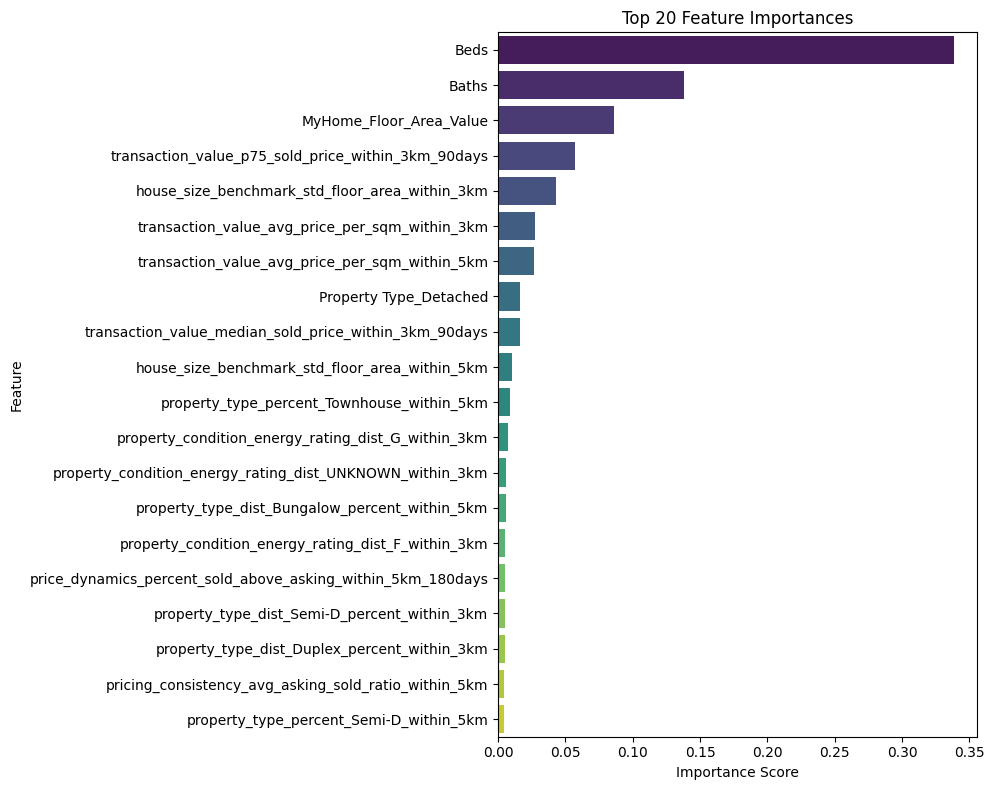


Final Test Dataset with Preserved Details and Predictions:
                                                Address  Beds  Baths  \
1511      116 Castle Farm, Shankill, Dublin 18, D18PK25   3.0    3.0   
1799  90 Milltown Hall, Mount Saint Annes, Milltown,...   2.0    2.0   
135      4 Cúil Dúin Way, Citywest, Co. Dublin, D24NX4D   3.0    3.0   
408   25 White Pines Meadow, Stocking Avenue, Dublin...   3.0    2.0   
1693  304 Richmond Court, Richmond Avenue South, Dar...   2.0    1.0   

      Sold Price Square Metres  BER  Actual Asking Price  \
1511    630000.0           N/A  N/A               595000   
1799    685000.0           N/A  N/A               630000   
135     476000.0           N/A  N/A               425000   
408     600000.0           N/A  N/A               585000   
1693    465000.0           N/A  N/A               450000   

      Predicted Asking Price  
1511           502956.000000  
1799           625616.666667  
135            380949.000000  
408            530870.

In [15]:
import pandas as pd
import numpy as np

# For preprocessing and model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# For handling missing values
from sklearn.impute import SimpleImputer

# For evaluation
from sklearn.metrics import mean_squared_error, r2_score

# For feature importance visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For version checking
import sklearn
from packaging import version

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Check scikit-learn version
sklearn_version = sklearn.__version__
print(f"scikit-learn version: {sklearn_version}")

# 1. Load the Data
# Replace 'house_data.csv' with your actual data file path
# Assuming df_with_metrics is your DataFrame loaded elsewhere
df = df_with_metrics

# 2. Initial Data Inspection
print("Initial Data Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

# =========================================
# Step 2: Preserve Relevant Columns Before Dropping
# =========================================

# Define the columns you want to preserve
columns_to_preserve = {
    'Address': ['Address', 'MyHome_Address'],
    'Beds': ['Beds', 'MyHome_Beds'],
    'Baths': ['Baths', 'MyHome_Baths'],
    'Sold Price': ['Sold Price', 'MyHome_Sold_Price'],
    'Square Metres': ['Square Metres', 'MyHome_Square_Metres'],  # Added Square Metres
    'BER': ['BER', 'MyHome_BER']  # Added BER
}

# Initialize an empty DataFrame to store preserved columns
preserved_df = pd.DataFrame(index=df.index)

# Extract each column if it exists
for key, possible_cols in columns_to_preserve.items():
    for col in possible_cols:
        if col in df.columns:
            preserved_df[key] = df[col]
            break
    else:
        # If none of the possible columns are found, assign 'N/A' or appropriate default
        preserved_df[key] = 'N/A'

print("\nPreserved Columns:")
print(preserved_df.head())

# =========================================

# 3. Drop the 'price_per_square_meter' Column if present
if 'price_per_square_meter' in df.columns:
    df = df.drop('price_per_square_meter', axis=1)
    print("\nDropped 'price_per_square_meter' column.")

# 4. Drop Irrelevant, Leakage Columns, and Ensure Local Property Tax is Removed
columns_to_drop = [
    'Address', 'URL', 'MyHome_Address', 'MyHome_Link',
    'Agency Name', 'Agency Contact', 'Sold Asking Price',
    'Sold Price', 'Sold Date', 'First List Date',
    'Local Property Tax'  # Corrected column name
]

# Drop columns if they exist in the dataframe
existing_drop_columns = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_drop_columns, axis=1)
print(f"\nDropped columns: {existing_drop_columns}")

# 5. Define the Target Variable
target = 'Asking Price'

if target not in df.columns:
    raise ValueError(f"Target variable '{target}' not found in the dataset.")

# 6. Separate Features and Target
X = df.drop(target, axis=1)
y = df[target]

print("\nFeatures shape:", X.shape)
print("Target shape:", y.shape)

# =========================================
# Step 3: Modify Train-Test Split to Include Preserved Columns
# =========================================

# Ensure that the preserved DataFrame aligns with the current DataFrame
preserved_df = preserved_df.loc[X.index]

# Split the data and the preserved columns
X_train, X_test, y_train, y_test, preserved_train, preserved_test = train_test_split(
    X, y, preserved_df, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nPreserved Training set shape:", preserved_train.shape)
print("Preserved Test set shape:", preserved_test.shape)

# =========================================

# 7. Further Drop Columns that May Cause Leakage or Are Irrelevant
leakage_columns = [
    'transaction_volume_num_sold_within_3km_90days',
    'transaction_volume_avg_monthly_transactions_within_3km'
]

existing_leakage_columns = [col for col in leakage_columns if col in X_train.columns]
X_train = X_train.drop(columns=existing_leakage_columns, axis=1)
X_test = X_test.drop(columns=existing_leakage_columns, axis=1)
print(f"\nDropped leakage columns: {existing_leakage_columns}")

# Update numerical and categorical columns after dropping leakage columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# 8. Handle High Cardinality Columns (Optional)
if 'Eircode' in categorical_cols:
    X_train = X_train.drop('Eircode', axis=1)
    X_test = X_test.drop('Eircode', axis=1)
    categorical_cols.remove('Eircode')
    print("\nDropped 'Eircode' due to high cardinality.")

# 9. Ensure Numerical Columns are Numeric
for col in numerical_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# 10. Ensure Categorical Columns are of type 'str'
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# 11. Check for Remaining Missing Values
print("\nMissing values per column in Training Set:")
print(X_train.isnull().sum())

print("\nMissing values per column in Test Set:")
print(X_test.isnull().sum())

# 12. Drop Columns with Excessive Missing Values
threshold = 0.5  # Drop columns with more than 50% missing values
missing_fraction_train = X_train.isnull().mean()
columns_to_drop_missing = missing_fraction_train[missing_fraction_train > threshold].index.tolist()
if columns_to_drop_missing:
    X_train = X_train.drop(columns=columns_to_drop_missing, axis=1)
    X_test = X_test.drop(columns=columns_to_drop_missing, axis=1)
    numerical_cols = [col for col in numerical_cols if col not in columns_to_drop_missing]
    categorical_cols = [col for col in categorical_cols if col not in columns_to_drop_missing]
    print(f"\nDropped columns with >50% missing values: {columns_to_drop_missing}")

# 13. Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Adjust OneHotEncoder parameter based on scikit-learn version
if version.parse(sklearn_version) >= version.parse("1.2"):
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', onehot_encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 14. Create the Modeling Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1
    ))
])

# 15. Train the Model
try:
    model_pipeline.fit(X_train, y_train)
    print("\nModel training completed.")
except ValueError as e:
    print("\nError during model training:", e)
    raise

# 16. Make Predictions on the Test Set
y_pred = model_pipeline.predict(X_test)

# 17. Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest Regressor Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.2f}")

# 18. Feature Importance Analysis
def get_feature_names(preprocessor, numerical_cols, categorical_cols):
    output_features = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            output_features.extend(columns)
        elif name == 'cat':
            onehot = transformer.named_steps['onehot']
            if hasattr(onehot, 'get_feature_names_out'):
                cat_features = onehot.get_feature_names_out(columns)
            else:
                cat_features = onehot.get_feature_names(columns)
            output_features.extend(cat_features)
    return output_features

feature_names = get_feature_names(preprocessor, numerical_cols, categorical_cols)

if len(feature_names) != len(model_pipeline.named_steps['regressor'].feature_importances_):
    raise ValueError("Mismatch between number of feature names and feature importances.")

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_pipeline.named_steps['regressor'].feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

top_n = 20
top_features = feature_importances.head(top_n)

print(f"\nTop {top_n} Feature Importances:")
print(top_features)

# 19. Visualize Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# =========================================
# Step 4: Combine Preserved Test Data with Predictions
# =========================================

# Create a final DataFrame with preserved details, actual prices, and predictions
final_test_df = preserved_test.copy()

# Ensure 'Sold Price' is numeric for formatting
final_test_df['Sold Price'] = pd.to_numeric(final_test_df['Sold Price'], errors='coerce')

# Add Actual and Predicted Asking Prices
final_test_df['Actual Asking Price'] = y_test.values
final_test_df['Predicted Asking Price'] = y_pred

# If you have other preserved columns, include them as needed

print("\nFinal Test Dataset with Preserved Details and Predictions:")
print(final_test_df.head())

# Optionally, save the final_test_df to a CSV for further analysis
# final_test_df.to_csv('final_test_predictions.csv', index=False)

# =========================================
# Step 5: Define the `predict_and_compare` Function
# =========================================

# Function to predict and compare a specific row
def predict_and_compare(sample_index=None, unique_id=None):
    """
    Predicts the asking price for a specific row and compares it with the actual price.
    
    Parameters:
    - sample_index (int): The index of the row in X_test.
    - unique_id (Any): The unique identifier of the row (if applicable).
    
    Note: Provide either sample_index or unique_id.
    """
    if sample_index is not None:
        try:
            sample = X_test.iloc[[sample_index]]  # Select as DataFrame
            actual_price = y_test.iloc[sample_index]
            
            # Access preserved details from final_test_df
            address = final_test_df.iloc[sample_index]['Address']
            beds = final_test_df.iloc[sample_index]['Beds']
            baths = final_test_df.iloc[sample_index]['Baths']
            sold_price = final_test_df.iloc[sample_index]['Sold Price']
            square_metres = final_test_df.iloc[sample_index]['Square Metres']  # Retrieved Square Metres
            ber = final_test_df.iloc[sample_index]['BER']  # Retrieved BER
            
            print(f"\nSelected Row Index: {X_test.index[sample_index]}")
        except IndexError:
            print("Error: Sample index out of range.")
            return
        except KeyError as e:
            print(f"Error: Missing column in final_test_df - {e}")
            return
    elif unique_id is not None:
        if 'ID' not in final_test_df.columns:
            print("Error: 'ID' column not found in the dataset.")
            return
        sample = X_test[X_test['ID'] == unique_id]
        if sample.empty:
            print(f"Error: No row found with ID = {unique_id}.")
            return
        sample = sample  # Already a DataFrame
        actual_price = y_test[X_test['ID'] == unique_id].iloc[0]
        
        # Access preserved details from final_test_df
        address = final_test_df[final_test_df['ID'] == unique_id]['Address'].iloc[0]
        beds = final_test_df[final_test_df['ID'] == unique_id]['Beds'].iloc[0]
        baths = final_test_df[final_test_df['ID'] == unique_id]['Baths'].iloc[0]
        sold_price = final_test_df[final_test_df['ID'] == unique_id]['Sold Price'].iloc[0]
        square_metres = final_test_df[final_test_df['ID'] == unique_id]['Square Metres'].iloc[0]  # Retrieved Square Metres
        ber = final_test_df[final_test_df['ID'] == unique_id]['BER'].iloc[0]  # Retrieved BER
        
        print(f"\nSelected Row ID: {unique_id}")
    else:
        print("Error: Please provide either sample_index or unique_id.")
        return
    
    # Display Preserved Property Details
    print(f"Address: {address}")
    print(f"Beds: {beds}")
    print(f"Baths: {baths}")
    print(f"Sold Price: {sold_price:,.2f}")
    print(f"Square Metres: {square_metres}")
    print(f"BER: {ber}")
    print(f"Actual Asking Price: {actual_price:,.2f}")
    
    # Predict
    try:
        predicted_price = model_pipeline.predict(sample)[0]
        print(f"Predicted Asking Price: {predicted_price:,.2f}")
    except Exception as e:
        print(f"Error during prediction: {e}")
        return
    
    # Compare
    difference = predicted_price - actual_price
    try:
        percentage_error = (difference / actual_price) * 100
    except ZeroDivisionError:
        percentage_error = np.nan  # Handle division by zero if actual_price is 0
    
    print(f"Difference: {difference:,.2f}")
    if not np.isnan(percentage_error):
        print(f"Percentage Error: {percentage_error:.2f}%")
    else:
        print("Percentage Error: Undefined (Actual Asking Price is 0)")

# Example Usage:
predict_and_compare(sample_index=120)

# =========================================


In [36]:
# Example Usage:
predict_and_compare(sample_index=120)


Selected Row Index: 1762
Address: 38 Mount Eagle View, Leopardstown Heights, Leopardstown, Dublin 18, D18P6C7
Beds: 3.0
Baths: 1.0
Sold Price: 605,000.00
Square Metres: N/A
BER: N/A
Actual Asking Price: 545,000.00
Predicted Asking Price: 595,928.50
Difference: 50,928.50
Percentage Error: 9.34%


scikit-learn version: 1.5.2
Initial Data Shape: (1821, 163)

Data Types:
Address                                          object
Asking Price                                      int64
Beds                                            float64
Baths                                           float64
Property Type                                    object
                                                 ...   
property_type_dist_Site_percent_within_5km      float64
sales_velocity_seasonal_month_3_within_5km      float64
sales_velocity_count_2024-03_within_3km         float64
property_type_dist_Houses_percent_within_3km    float64
property_condition_ber_dist_15.0_within_3km     float64
Length: 163, dtype: object

Preserved Columns:
                                             Address  Beds  Baths  Sold Price  \
0           Taramar, Middle Third, Dublin 5, D05X8N9   4.0    1.0    950000.0   
1              87 Haddington Road, Dublin 4, D04WP23   5.0    3.0   1010000.0   
2  Apartment 79, The 

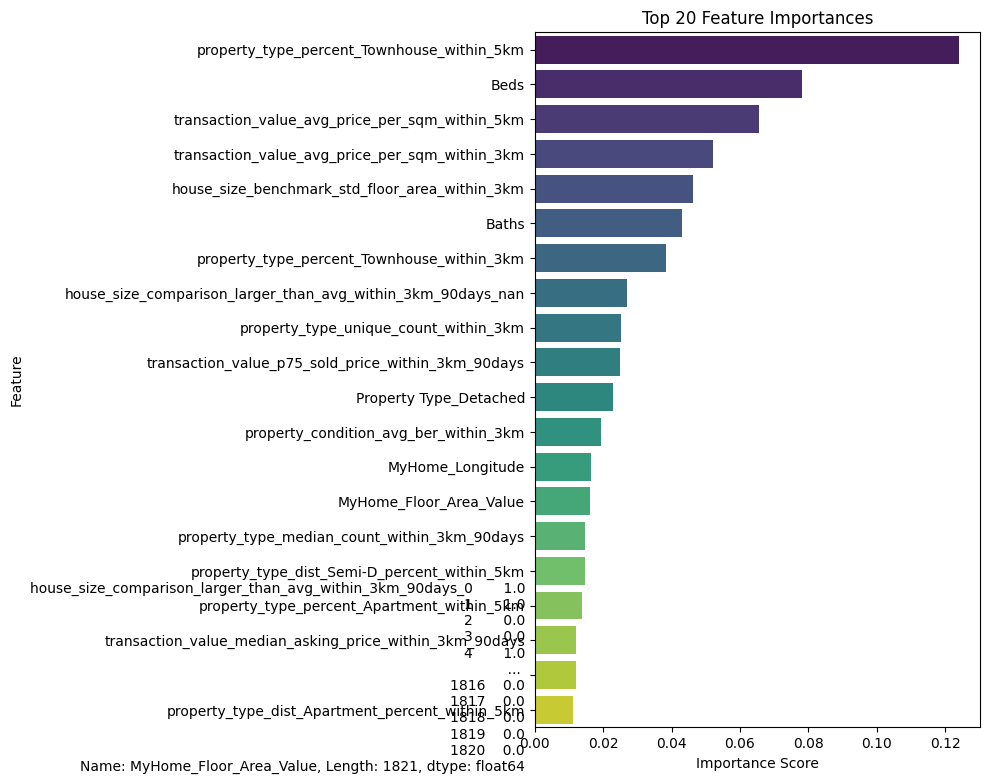


Final Test Dataset with Preserved Details and Predictions:
                                                Address  Beds  Baths  \
1511      116 Castle Farm, Shankill, Dublin 18, D18PK25   3.0    3.0   
1799  90 Milltown Hall, Mount Saint Annes, Milltown,...   2.0    2.0   
135      4 Cúil Dúin Way, Citywest, Co. Dublin, D24NX4D   3.0    3.0   
408   25 White Pines Meadow, Stocking Avenue, Dublin...   3.0    2.0   
1693  304 Richmond Court, Richmond Avenue South, Dar...   2.0    1.0   

      Sold Price Square Metres  BER  Actual Asking Price  \
1511    630000.0           N/A  N/A               595000   
1799    685000.0           N/A  N/A               630000   
135     476000.0           N/A  N/A               425000   
408     600000.0           N/A  N/A               585000   
1693    465000.0           N/A  N/A               450000   

      Predicted Asking Price  
1511             534685.4375  
1799             580030.6875  
135              408462.9375  
408              53476

In [37]:
import pandas as pd
import numpy as np

# For preprocessing and model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Updated: Import XGBoost Regressor
from xgboost import XGBRegressor

# For handling missing values
from sklearn.impute import SimpleImputer

# For evaluation
from sklearn.metrics import mean_squared_error, r2_score

# For feature importance visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For version checking
import sklearn
from packaging import version

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Check scikit-learn version
sklearn_version = sklearn.__version__
print(f"scikit-learn version: {sklearn_version}")

# 1. Load the Data
# Replace 'house_data.csv' with your actual data file path
# Assuming df_with_metrics is your DataFrame loaded elsewhere
df = df_with_metrics

# 2. Initial Data Inspection
print("Initial Data Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

# =========================================
# Step 2: Preserve Relevant Columns Before Dropping
# =========================================

# Define the columns you want to preserve
columns_to_preserve = {
    'Address': ['Address', 'MyHome_Address'],
    'Beds': ['Beds', 'MyHome_Beds'],
    'Baths': ['Baths', 'MyHome_Baths'],
    'Sold Price': ['Sold Price', 'MyHome_Sold_Price'],
    'Square Metres': ['Square Metres', 'Square_Metres', 'MyHome_Square_Metres'],  # Updated to include variations
    'BER': ['BER', 'BER_Rating', 'MyHome_BER']  # Updated to include variations
}

# Initialize an empty DataFrame to store preserved columns
preserved_df = pd.DataFrame(index=df.index)

# Extract each column if it exists
for key, possible_cols in columns_to_preserve.items():
    for col in possible_cols:
        if col in df.columns:
            preserved_df[key] = df[col]
            break
    else:
        # If none of the possible columns are found, assign 'N/A' or appropriate default
        preserved_df[key] = 'N/A'

print("\nPreserved Columns:")
print(preserved_df.head())

# =========================================

# 3. Drop the 'price_per_square_meter' Column if present
if 'price_per_square_meter' in df.columns:
    df = df.drop('price_per_square_meter', axis=1)
    print("\nDropped 'price_per_square_meter' column.")

# 4. Drop Irrelevant, Leakage Columns, and Ensure Local Property Tax is Removed
columns_to_drop = [
    'Address', 'URL', 'MyHome_Address', 'MyHome_Link',
    'Agency Name', 'Agency Contact', 'Sold Asking Price',
    'Sold Price', 'Sold Date', 'First List Date',
    'Local Property Tax'  # Corrected column name
]

# Drop columns if they exist in the dataframe
existing_drop_columns = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_drop_columns, axis=1)
print(f"\nDropped columns: {existing_drop_columns}")

# 5. Define the Target Variable
target = 'Asking Price'

if target not in df.columns:
    raise ValueError(f"Target variable '{target}' not found in the dataset.")

# 6. Separate Features and Target
X = df.drop(target, axis=1)
y = df[target]

print("\nFeatures shape:", X.shape)
print("Target shape:", y.shape)

# =========================================
# Step 3: Modify Train-Test Split to Include Preserved Columns
# =========================================

# Ensure that the preserved DataFrame aligns with the current DataFrame
preserved_df = preserved_df.loc[X.index]

# Split the data and the preserved columns
X_train, X_test, y_train, y_test, preserved_train, preserved_test = train_test_split(
    X, y, preserved_df, test_size=0.2, random_state=42)
    
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nPreserved Training set shape:", preserved_train.shape)
print("Preserved Test set shape:", preserved_test.shape)

# =========================================

# 7. Further Drop Columns that May Cause Leakage or Are Irrelevant
leakage_columns = [
    'transaction_volume_num_sold_within_3km_90days',
    'transaction_volume_avg_monthly_transactions_within_3km'
]

existing_leakage_columns = [col for col in leakage_columns if col in X_train.columns]
X_train = X_train.drop(columns=existing_leakage_columns, axis=1)
X_test = X_test.drop(columns=existing_leakage_columns, axis=1)
print(f"\nDropped leakage columns: {existing_leakage_columns}")

# Update numerical and categorical columns after dropping leakage columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# 8. Handle High Cardinality Columns (Optional)
if 'Eircode' in categorical_cols:
    X_train = X_train.drop('Eircode', axis=1)
    X_test = X_test.drop('Eircode', axis=1)
    categorical_cols.remove('Eircode')
    print("\nDropped 'Eircode' due to high cardinality.")

# 9. Ensure Numerical Columns are Numeric
for col in numerical_cols:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# 10. Ensure Categorical Columns are of type 'str'
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# 11. Check for Remaining Missing Values
print("\nMissing values per column in Training Set:")
print(X_train.isnull().sum())

print("\nMissing values per column in Test Set:")
print(X_test.isnull().sum())

# 12. Drop Columns with Excessive Missing Values
threshold = 0.5  # Drop columns with more than 50% missing values
missing_fraction_train = X_train.isnull().mean()
columns_to_drop_missing = missing_fraction_train[missing_fraction_train > threshold].index.tolist()
if columns_to_drop_missing:
    X_train = X_train.drop(columns=columns_to_drop_missing, axis=1)
    X_test = X_test.drop(columns=columns_to_drop_missing, axis=1)
    numerical_cols = [col for col in numerical_cols if col not in columns_to_drop_missing]
    categorical_cols = [col for col in categorical_cols if col not in columns_to_drop_missing]
    print(f"\nDropped columns with >50% missing values: {columns_to_drop_missing}")

# 13. Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Adjust OneHotEncoder parameter based on scikit-learn version
if version.parse(sklearn_version) >= version.parse("1.2"):
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', onehot_encoder)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 14. Create the Modeling Pipeline with XGBoost
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror'  # Specify the objective for regression
    ))
])

# 15. Train the Model
try:
    model_pipeline.fit(X_train, y_train)
    print("\nModel training completed.")
except ValueError as e:
    print("\nError during model training:", e)
    raise

# 16. Make Predictions on the Test Set
y_pred = model_pipeline.predict(X_test)

# 17. Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nXGBoost Regressor Performance on Test Set:")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.2f}")

# 18. Feature Importance Analysis
def get_feature_names(preprocessor, numerical_cols, categorical_cols):
    output_features = []

    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            output_features.extend(columns)
        elif name == 'cat':
            onehot = transformer.named_steps['onehot']
            if hasattr(onehot, 'get_feature_names_out'):
                cat_features = onehot.get_feature_names_out(columns)
            else:
                cat_features = onehot.get_feature_names(columns)
            output_features.extend(cat_features)
    return output_features

feature_names = get_feature_names(preprocessor, numerical_cols, categorical_cols)

if len(feature_names) != len(model_pipeline.named_steps['regressor'].feature_importances_):
    raise ValueError("Mismatch between number of feature names and feature importances.")

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model_pipeline.named_steps['regressor'].feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

top_n = 20
top_features = feature_importances.head(top_n)

print(f"\nTop {top_n} Feature Importances:")
print(top_features)

# 19. Visualize Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# =========================================
# Step 4: Combine Preserved Test Data with Predictions
# =========================================

# Create a final DataFrame with preserved details, actual prices, and predictions
final_test_df = preserved_test.copy()

# Ensure 'Sold Price' is numeric for formatting
final_test_df['Sold Price'] = pd.to_numeric(final_test_df['Sold Price'], errors='coerce')

# Add Actual and Predicted Asking Prices
final_test_df['Actual Asking Price'] = y_test.values
final_test_df['Predicted Asking Price'] = y_pred

# If you have other preserved columns, include them as needed

print("\nFinal Test Dataset with Preserved Details and Predictions:")
print(final_test_df.head())

# Optionally, save the final_test_df to a CSV for further analysis
# final_test_df.to_csv('final_test_predictions_xgboost.csv', index=False)

# =========================================
# Step 5: Define the `predict_and_compare` Function
# =========================================

# Function to predict and compare a specific row
def predict_and_compare(sample_index=None, unique_id=None):
    """
    Predicts the asking price for a specific row and compares it with the actual price.
    
    Parameters:
    - sample_index (int): The index of the row in X_test.
    - unique_id (Any): The unique identifier of the row (if applicable).
    
    Note: Provide either sample_index or unique_id.
    """
    if sample_index is not None:
        try:
            sample = X_test.iloc[[sample_index]]  # Select as DataFrame
            actual_price = y_test.iloc[sample_index]
            
            # Access preserved details from final_test_df
            address = final_test_df.iloc[sample_index]['Address']
            beds = final_test_df.iloc[sample_index]['Beds']
            baths = final_test_df.iloc[sample_index]['Baths']
            sold_price = final_test_df.iloc[sample_index]['Sold Price']
            square_metres = final_test_df.iloc[sample_index]['Square Metres']  # Retrieved Square Metres
            ber = final_test_df.iloc[sample_index]['BER']  # Retrieved BER
            
            print(f"\nSelected Row Index: {X_test.index[sample_index]}")
        except IndexError:
            print("Error: Sample index out of range.")
            return
        except KeyError as e:
            print(f"Error: Missing column in final_test_df - {e}")
            return
    elif unique_id is not None:
        if 'ID' not in final_test_df.columns:
            print("Error: 'ID' column not found in the dataset.")
            return
        sample = X_test[X_test['ID'] == unique_id]
        if sample.empty:
            print(f"Error: No row found with ID = {unique_id}.")
            return
        sample = sample  # Already a DataFrame
        actual_price = y_test[X_test['ID'] == unique_id].iloc[0]
        
        # Access preserved details from final_test_df
        address = final_test_df[final_test_df['ID'] == unique_id]['Address'].iloc[0]
        beds = final_test_df[final_test_df['ID'] == unique_id]['Beds'].iloc[0]
        baths = final_test_df[final_test_df['ID'] == unique_id]['Baths'].iloc[0]
        sold_price = final_test_df[final_test_df['ID'] == unique_id]['Sold Price'].iloc[0]
        square_metres = final_test_df[final_test_df['ID'] == unique_id]['Square Metres'].iloc[0]  # Retrieved Square Metres
        ber = final_test_df[final_test_df['ID'] == unique_id]['BER'].iloc[0]  # Retrieved BER
        
        print(f"\nSelected Row ID: {unique_id}")
    else:
        print("Error: Please provide either sample_index or unique_id.")
        return
    
    # Display Preserved Property Details
    print(f"Address: {address}")
    print(f"Beds: {beds}")
    print(f"Baths: {baths}")
    print(f"Sold Price: {sold_price:,.2f}")
    print(f"Square Metres: {square_metres}")
    print(f"BER: {ber}")
    print(f"Actual Asking Price: {actual_price:,.2f}")
    
    # Predict
    try:
        predicted_price = model_pipeline.predict(sample)[0]
        print(f"Predicted Asking Price: {predicted_price:,.2f}")
    except Exception as e:
        print(f"Error during prediction: {e}")
        return
    
    # Compare
    difference = predicted_price - actual_price
    try:
        percentage_error = (difference / actual_price) * 100
    except ZeroDivisionError:
        percentage_error = np.nan  # Handle division by zero if actual_price is 0
    
    print(f"Difference: {difference:,.2f}")
    if not np.isnan(percentage_error):
        print(f"Percentage Error: {percentage_error:.2f}%")
    else:
        print("Percentage Error: Undefined (Actual Asking Price is 0)")

# Example Usage:
predict_and_compare(sample_index=120)

# =========================================
